Single Driver Telemetry Analysis

This notebook explores and wrangles telemetry data from the Fast-F1 API for critical turns for a single driver. It establishes a structured workflow for data acquisition, preparation, and initial exploration before scaling to multi-driver analysis. Descriptive statistics and visualization functions provide dynamic insights into the data to identify patterns or anomalies, and guide subsequent feature engineering and modeling decisions.

NOTE: This notebook will not compile as standalone. Please pull down the project from GitHub (git clone https://github.com/yourusername/f1-driving-style-analytics-tool.git) and install the necessary dependencies. Further instruction is included in the README.md

The code below adds the parent directory to Python’s module search path and configures logging to suppress all FastF1 logs below the warning level. This will enable subsequent code blocks that use imports to work seamlessly and keep my resulting code compilations clean and easy to read.

In [32]:
import sys
import os
import logging

root = os.path.abspath("..")
sys.path.append(root)

logging.getLogger('fastf1').setLevel(logging.WARNING)

In this section, I import Python libraries for data visualization, numerical analysis, and working with Pandas dataframes that the FastF1 API is primarily structured with. I also import custom functions and modules for preprocessing F1 data and constants. To support full visibility into the datasets without truncation, I configure Pandas display options to show all rows and columns.

In [33]:
from src.data import f1_data
from src.utils import f1_constants, f1_pandas_helpers
from src.preprocessing import telemetry_cleaning, feature_engineering
from src.viz import plots

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)  # reset_option to compact dataframe view
pd.set_option('display.max_columns', None)


The following code initializes a single F1 race session by defining parameters such as year, location, and session type. These values are passed into the custom F1Session class (from f1_data.py), which creates a session object built on top of Fast-F1. This object provides access to race data as well as custom functions I’ve implemented.

The session parameters were chosen to best match Tier 1 control qualities:

- Weather: Abu Dhabi (clear, dry conditions)
- Max Speed: C5 Ultra Soft Tires
- Minimize Outliers: Qualifying Sessions (Q3 & Q2)
- Traffic: Avoid tow laps to avoid slipstream bias
- Corner Analysis → Isolates driver techniques

In [34]:
year = 2024
grand_prix = f1_constants.F1Constants.LOCATIONS["Abu Dhabi"]
session_type = f1_constants.F1Constants.SESSIONS["Q"]

session = f1_data.F1Session(year, grand_prix, session_type)

All drivers who participated in the specific location's Q2 and Q3 sessions will be analyzed and assigned variables to be identified by their three-letter name code. Q3 data will be used for each driver whenever available; otherwise, Q2 data will be selected.

Constants for telemetry data is also initialized as variables for ease of use during visualization.

In [35]:
# driver constants
norris = f1_constants.F1Constants.DRIVERS["Lando Norris"]
piastri = f1_constants.F1Constants.DRIVERS["Oscar Piastri"]
verstappen = f1_constants.F1Constants.DRIVERS["Max Verstappen"]
perez = f1_constants.F1Constants.DRIVERS["Sergio Perez"]
sainz = f1_constants.F1Constants.DRIVERS["Carlos Sainz"]
leclerc = f1_constants.F1Constants.DRIVERS["Charles Leclerc"]
bottas = f1_constants.F1Constants.DRIVERS["Valtteri Bottas"]
alonso = f1_constants.F1Constants.DRIVERS["Fernando Alonso"]
stroll = f1_constants.F1Constants.DRIVERS["Lance Stroll"]
gasly = f1_constants.F1Constants.DRIVERS["Pierre Gasly"]
hulkenberg = f1_constants.F1Constants.DRIVERS["Nico Hulkenberg"]
magnussen = f1_constants.F1Constants.DRIVERS["Kevin Magnussen"]
lawson = f1_constants.F1Constants.DRIVERS["Liam Lawson"]
tsunoda = f1_constants.F1Constants.DRIVERS["Yuki Tsunoda"]
russell = f1_constants.F1Constants.DRIVERS["George Russell"]

# telemetry constants
speed = f1_constants.F1Constants.TELEMETRY_COLUMNS["Speed (m/s)"]
acceleration = f1_constants.F1Constants.TELEMETRY_COLUMNS["Acceleration (m/s²)"]
jerk = f1_constants.F1Constants.TELEMETRY_COLUMNS["Jerk (m/s³)"]
rpm = f1_constants.F1Constants.TELEMETRY_COLUMNS["RPM"]
g_force = f1_constants.F1Constants.TELEMETRY_COLUMNS["G-force (g)"]
gear = f1_constants.F1Constants.TELEMETRY_COLUMNS["nGear"]
throttle = f1_constants.F1Constants.TELEMETRY_COLUMNS["Throttle (%)"]
brakes = f1_constants.F1Constants.TELEMETRY_COLUMNS["BrakesApplied"]

The code extracts circuit information for the session’s corners. The `critical_turn` array identifies corners where driver behavior is especially important for sector and overall lap performance. Adjusting the `radius` value controls how much telemetry around each turn is included, allowing you to visualize throttle and braking traces at the desired level of detail.

In [36]:
corner_position = session.get_circuit_info().corners
corner_position_cleaned = telemetry_cleaning.clean_circuit_corner_data(corner_position)

# 16 --> 2500, 12 --> 1800
critical_turn = [16]
radius = 2500

For each driver, the telemetry from their fastest qualifying lap is isolated by filtering based on sector timestamps. These sector datasets are then cleaned, enriched with derived features, and filtered by turn to focus on the segments most informative for analyzing driver behavior and responses in complex areas.

Q3 data for Lando Norris, McLaren

In [37]:
q1, q2, q3 = session.get_laps(norris).split_qualifying_sessions()
norris_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

norris_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=sector_1_start, end=sector_1_end)
norris_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_sector1_telemetry, norris)

norris_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=sector_1_end, end=sector_2_end)
norris_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_sector2_telemetry, norris)

norris_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(norris_q3_telemetry, start=sector_2_end, end=sector_3_end)
norris_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(norris_sector3_telemetry, norris)
norris_sector3_telemetry_features = feature_engineering.TelemetryFeatures(norris_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

norris_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(norris_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

norris_time_converted_telemetry = feature_engineering.TelemetryFeatures(norris_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (norris_time_converted_telemetry['BrakesApplied'] == 1) & (norris_time_converted_telemetry['BrakesApplied'].shift() == 0)
norris_initial_max_brake = norris_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()

Descriptive Statistics — Lando Norris - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [38]:
norris_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(norris_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
norris_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(norris, norris_turn_dfs, norris_initial_max_brake)

norris_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,NOR,16,63,2.485,4.602889,4,2,1


Visualizations - Lando Norris - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe. 
Limit the number of features to maintain clarity.

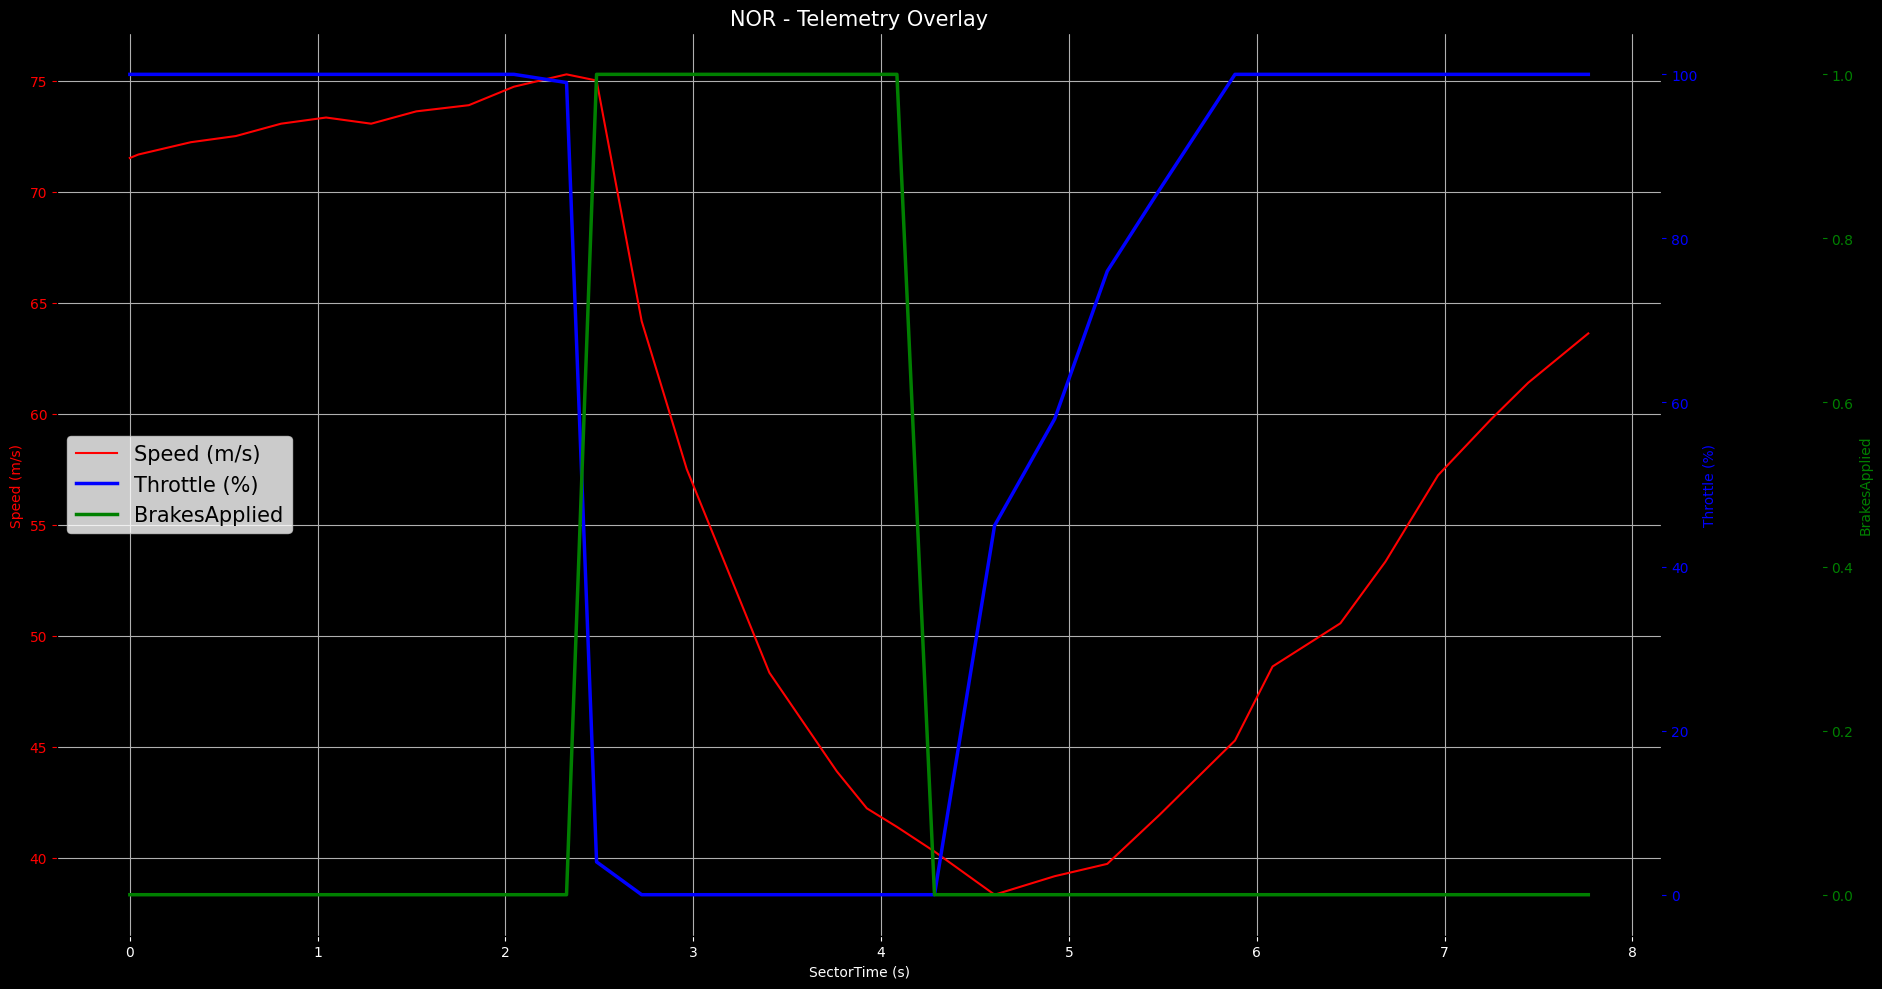

In [39]:
plots.plot_single_driver_telemetry(norris_corner_telemetry, norris, time_col='SectorTime (s)', telemetry_cols=[
    speed, throttle, brakes
    ])

Q3 data for Oscar Piastri, McLaren

In [40]:
q1, q2, q3 = session.get_laps(piastri).split_qualifying_sessions()
piastri_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

piastri_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=sector_1_start, end=sector_1_end)
piastri_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_sector1_telemetry, piastri)

piastri_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=sector_1_end, end=sector_2_end)
piastri_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_sector2_telemetry, piastri)

piastri_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(piastri_q3_telemetry, start=sector_2_end, end=sector_3_end)
piastri_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(piastri_sector3_telemetry, piastri)
piastri_sector3_telemetry_features = feature_engineering.TelemetryFeatures(piastri_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

piastri_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(piastri_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

piastri_time_converted_telemetry = feature_engineering.TelemetryFeatures(piastri_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (piastri_time_converted_telemetry['BrakesApplied'] == 1) & (piastri_time_converted_telemetry['BrakesApplied'].shift() == 0)
piastri_initial_max_brake = piastri_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()


Descriptive Statistics - Oscar Piastri - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [41]:
piastri_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(piastri_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
piastri_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(piastri, piastri_turn_dfs, piastri_initial_max_brake)

piastri_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,PIA,16,67,2.724,3.068595,5,2,1



Visualizations - Oscar Piastri - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe. 
Limit the number of features to maintain clarity.

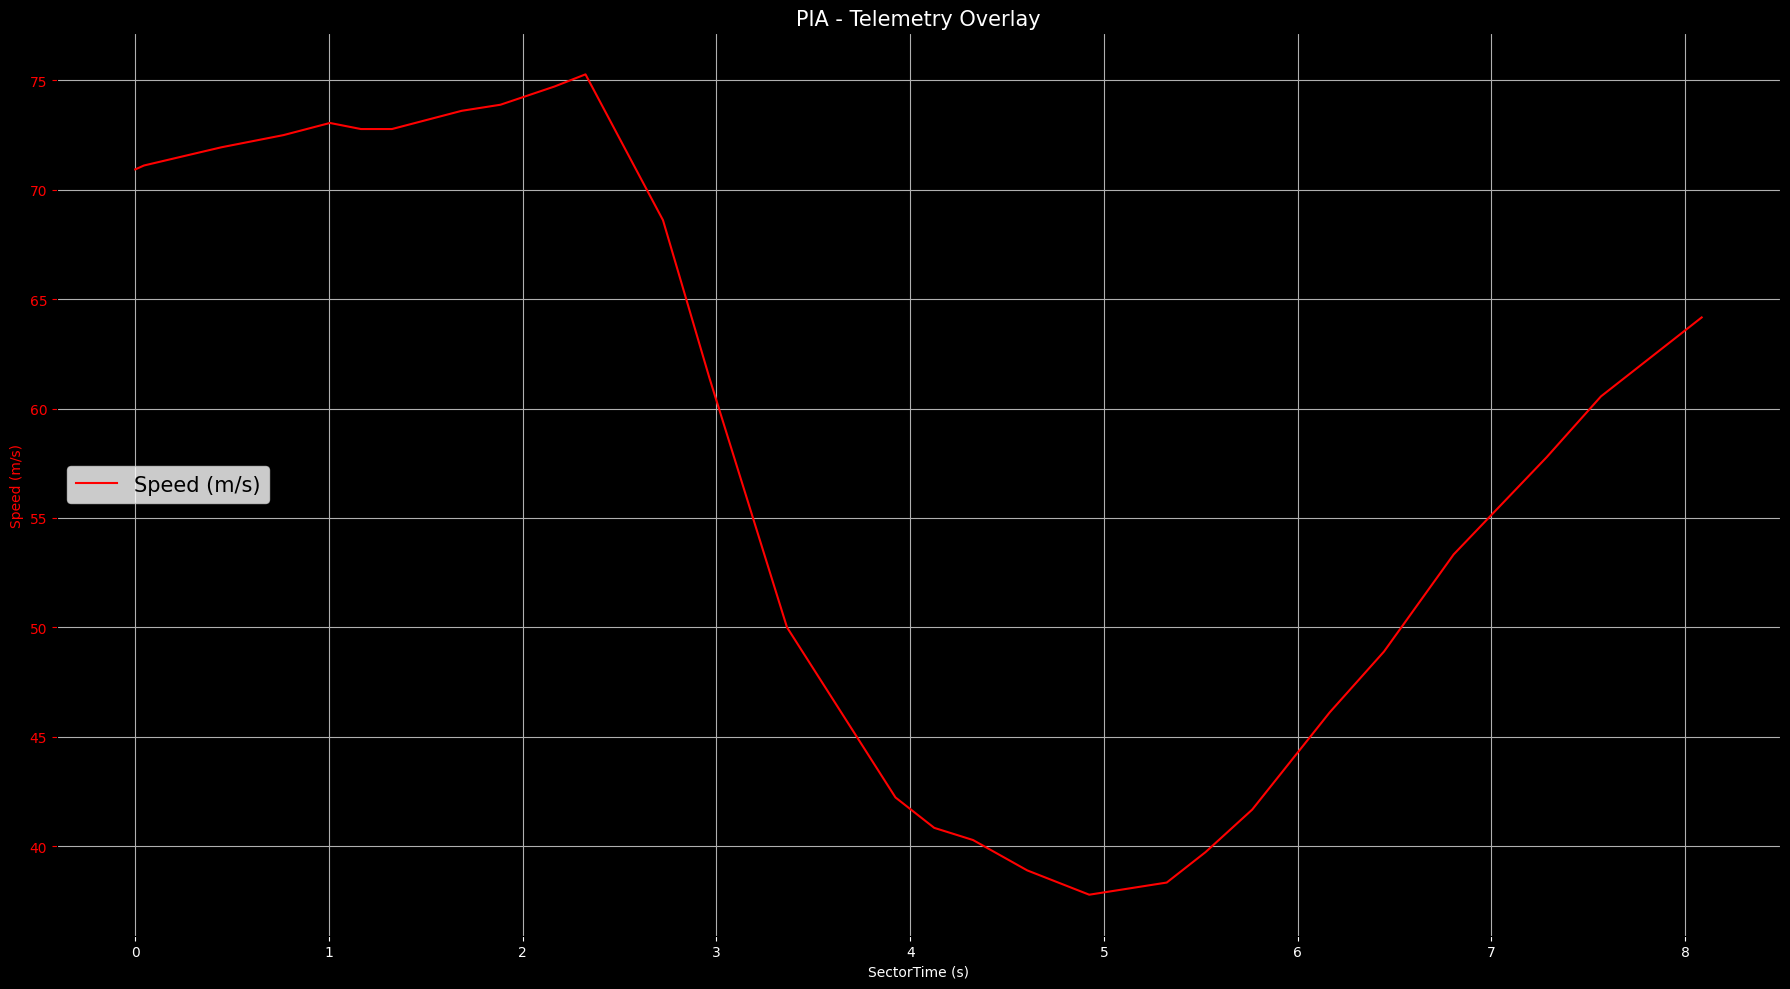

In [42]:
plots.plot_single_driver_telemetry(piastri_corner_telemetry, piastri, time_col='SectorTime (s)', telemetry_cols=[
    speed
])

Q3 data for Max Verstappen, Red Bull

In [43]:
q1, q2, q3 = session.get_laps(verstappen).split_qualifying_sessions()
verstappen_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

verstappen_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=sector_1_start, end=sector_1_end)
verstappen_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_sector1_telemetry, verstappen)

verstappen_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=sector_1_end, end=sector_2_end)
verstappen_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_sector2_telemetry, verstappen)

verstappen_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(verstappen_q3_telemetry, start=sector_2_end, end=sector_3_end)
verstappen_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(verstappen_sector3_telemetry, verstappen)
verstappen_sector3_telemetry_features = feature_engineering.TelemetryFeatures(verstappen_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

verstappen_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(verstappen_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

verstappen_time_converted_telemetry = feature_engineering.TelemetryFeatures(verstappen_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (verstappen_time_converted_telemetry['BrakesApplied'] == 1) & (verstappen_time_converted_telemetry['BrakesApplied'].shift() == 0)
verstappen_initial_max_brake = verstappen_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()


Descriptive Statistics - Max Verstappen - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [44]:
verstappen_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(verstappen_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
verstappen_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(verstappen, verstappen_turn_dfs, verstappen_initial_max_brake)

verstappen_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,VER,16,62,2.882,3.934345,4,2,1


Visualizations - Max Verstappen - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe.  
Limit the number of features to maintain clarity.

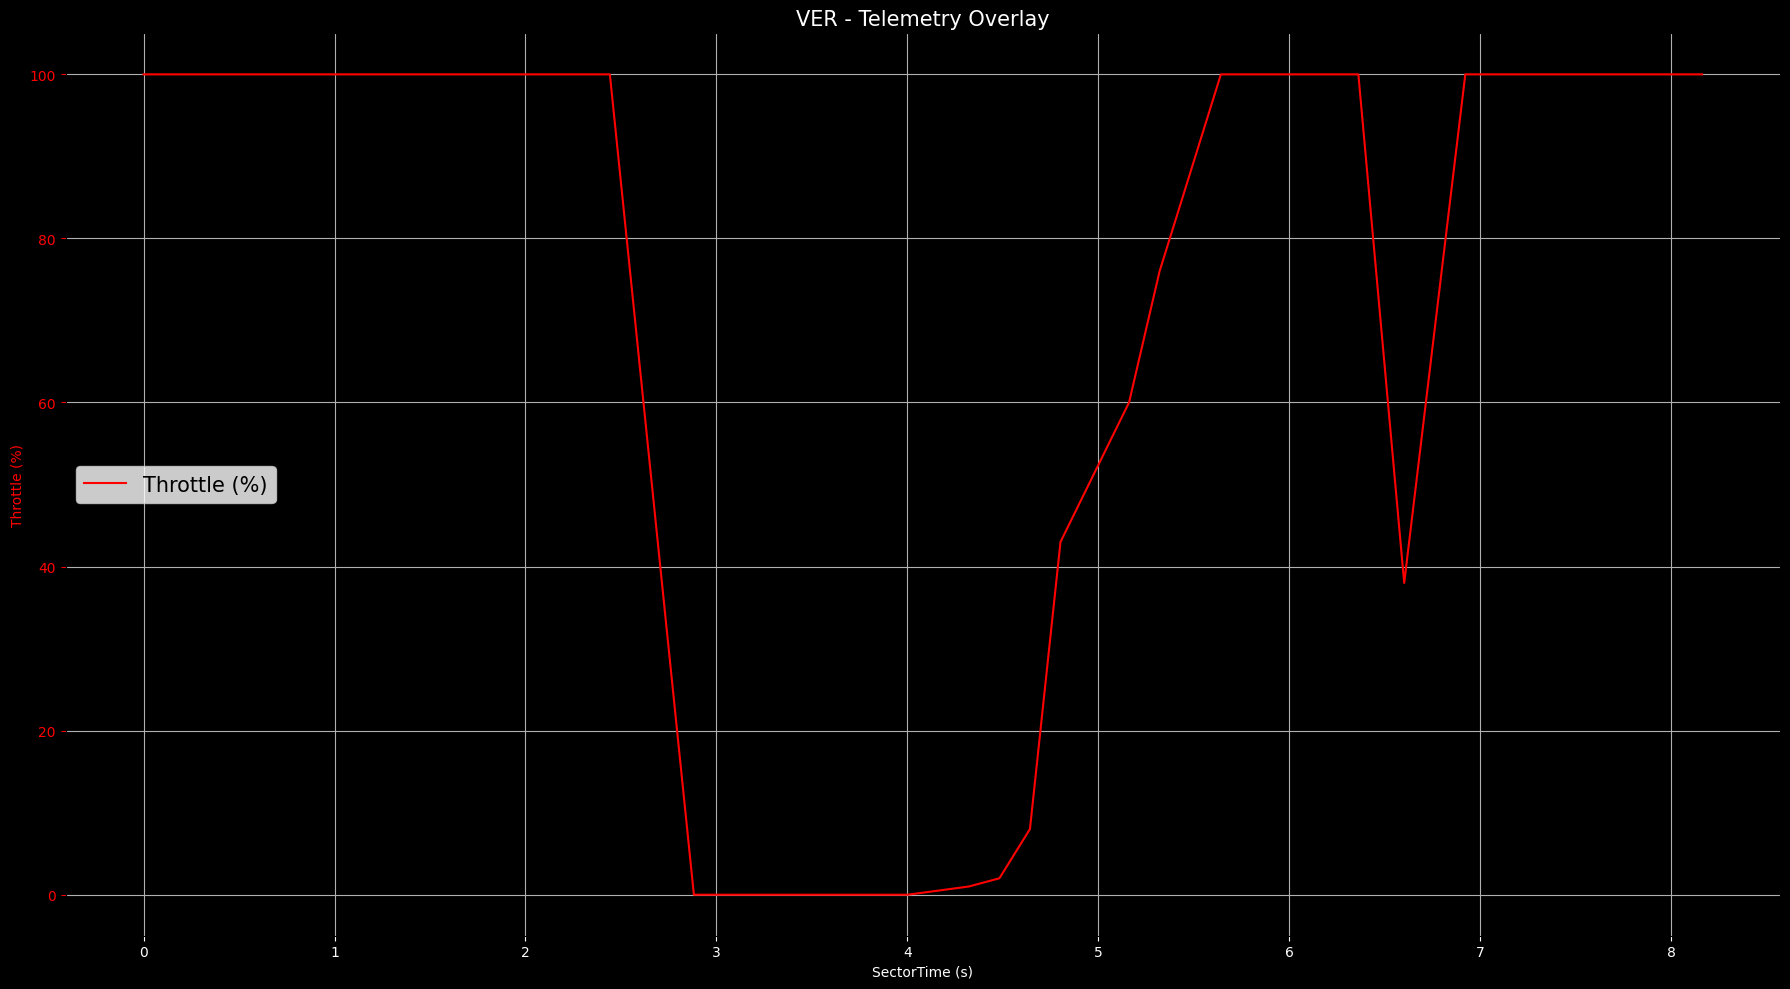

In [45]:
plots.plot_single_driver_telemetry(verstappen_corner_telemetry, verstappen, time_col='SectorTime (s)', telemetry_cols=[
    throttle
])

Q3 data for Sergio Perez, Red Bull

In [46]:
q1, q2, q3 = session.get_laps(perez).split_qualifying_sessions()
perez_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

perez_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=sector_1_start, end=sector_1_end)
perez_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_sector1_telemetry, perez)

perez_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=sector_1_end, end=sector_2_end)
perez_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_sector2_telemetry, perez)

perez_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(perez_q3_telemetry, start=sector_2_end, end=sector_3_end)
perez_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(perez_sector3_telemetry, perez)
perez_sector3_telemetry_features = feature_engineering.TelemetryFeatures(perez_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

perez_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(perez_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

perez_time_converted_telemetry = feature_engineering.TelemetryFeatures(perez_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (perez_time_converted_telemetry['BrakesApplied'] == 1) & (perez_time_converted_telemetry['BrakesApplied'].shift() == 0)
perez_initial_max_brake = perez_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()

Descriptive Statistics - Sergio Perez - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [47]:
perez_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(perez_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
perez_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(perez, perez_turn_dfs, perez_initial_max_brake)

perez_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,PER,16,64,2.783,3.717724,3,2,1


Visualizations - Sergio Perez - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe.  
Limit the number of features to maintain clarity.

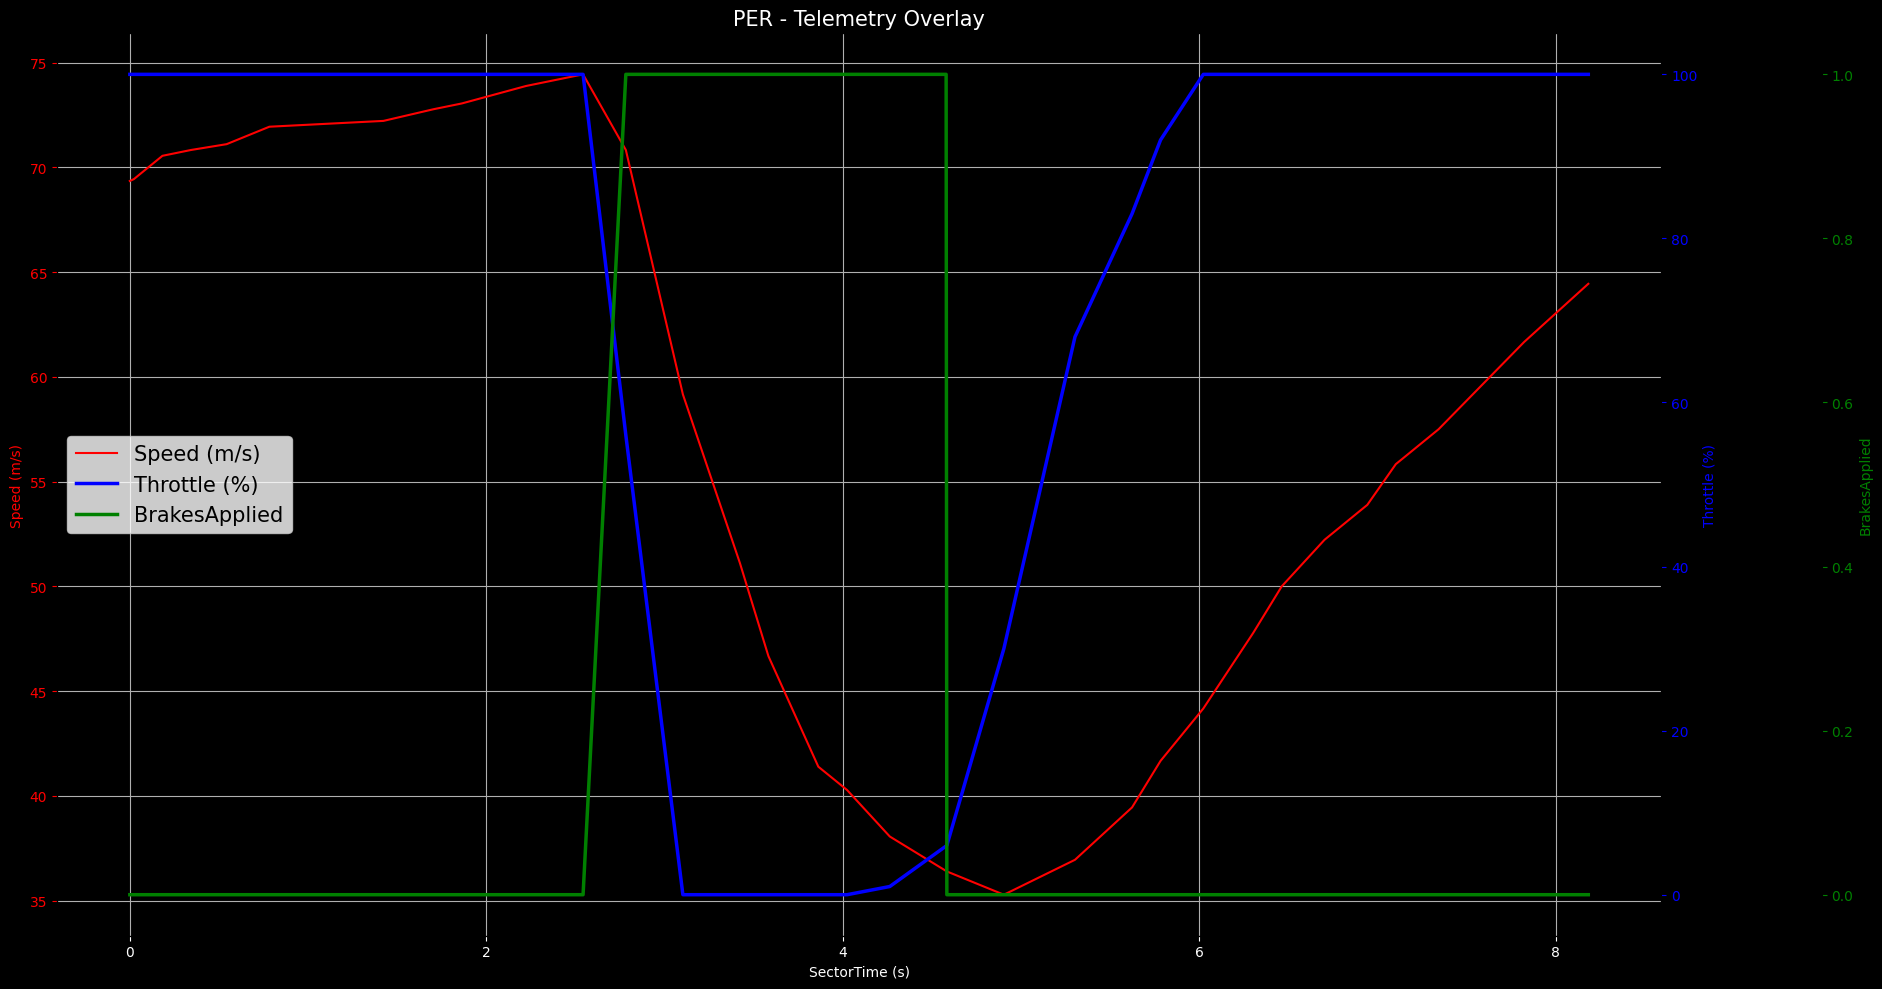

In [48]:
plots.plot_single_driver_telemetry(perez_corner_telemetry, perez, time_col='SectorTime (s)', telemetry_cols=[
    speed, throttle, brakes
])

Q3 data for Carlos Sainz, Ferrari

In [49]:
q1, q2, q3 = session.get_laps(sainz).split_qualifying_sessions()
sainz_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

sainz_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=sector_1_start, end=sector_1_end)
sainz_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_sector1_telemetry, sainz)

sainz_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=sector_1_end, end=sector_2_end)
sainz_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_sector2_telemetry, sainz)

sainz_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(sainz_q3_telemetry, start=sector_2_end, end=sector_3_end)
sainz_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(sainz_sector3_telemetry, sainz)
sainz_sector3_telemetry_features = feature_engineering.TelemetryFeatures(sainz_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

sainz_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(sainz_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

sainz_time_converted_telemetry = feature_engineering.TelemetryFeatures(sainz_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (sainz_time_converted_telemetry['BrakesApplied'] == 1) & (sainz_time_converted_telemetry['BrakesApplied'].shift() == 0)
sainz_initial_max_brake = sainz_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()

Descriptive Statistics - Carlos Sainz - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [50]:
sainz_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(sainz_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
sainz_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(sainz, sainz_turn_dfs, sainz_initial_max_brake)

sainz_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,SAI,16,64,2.76,3.540684,4,2,1


Visualizations - Carlos Sainz - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe.  
Limit the number of features to maintain clarity.

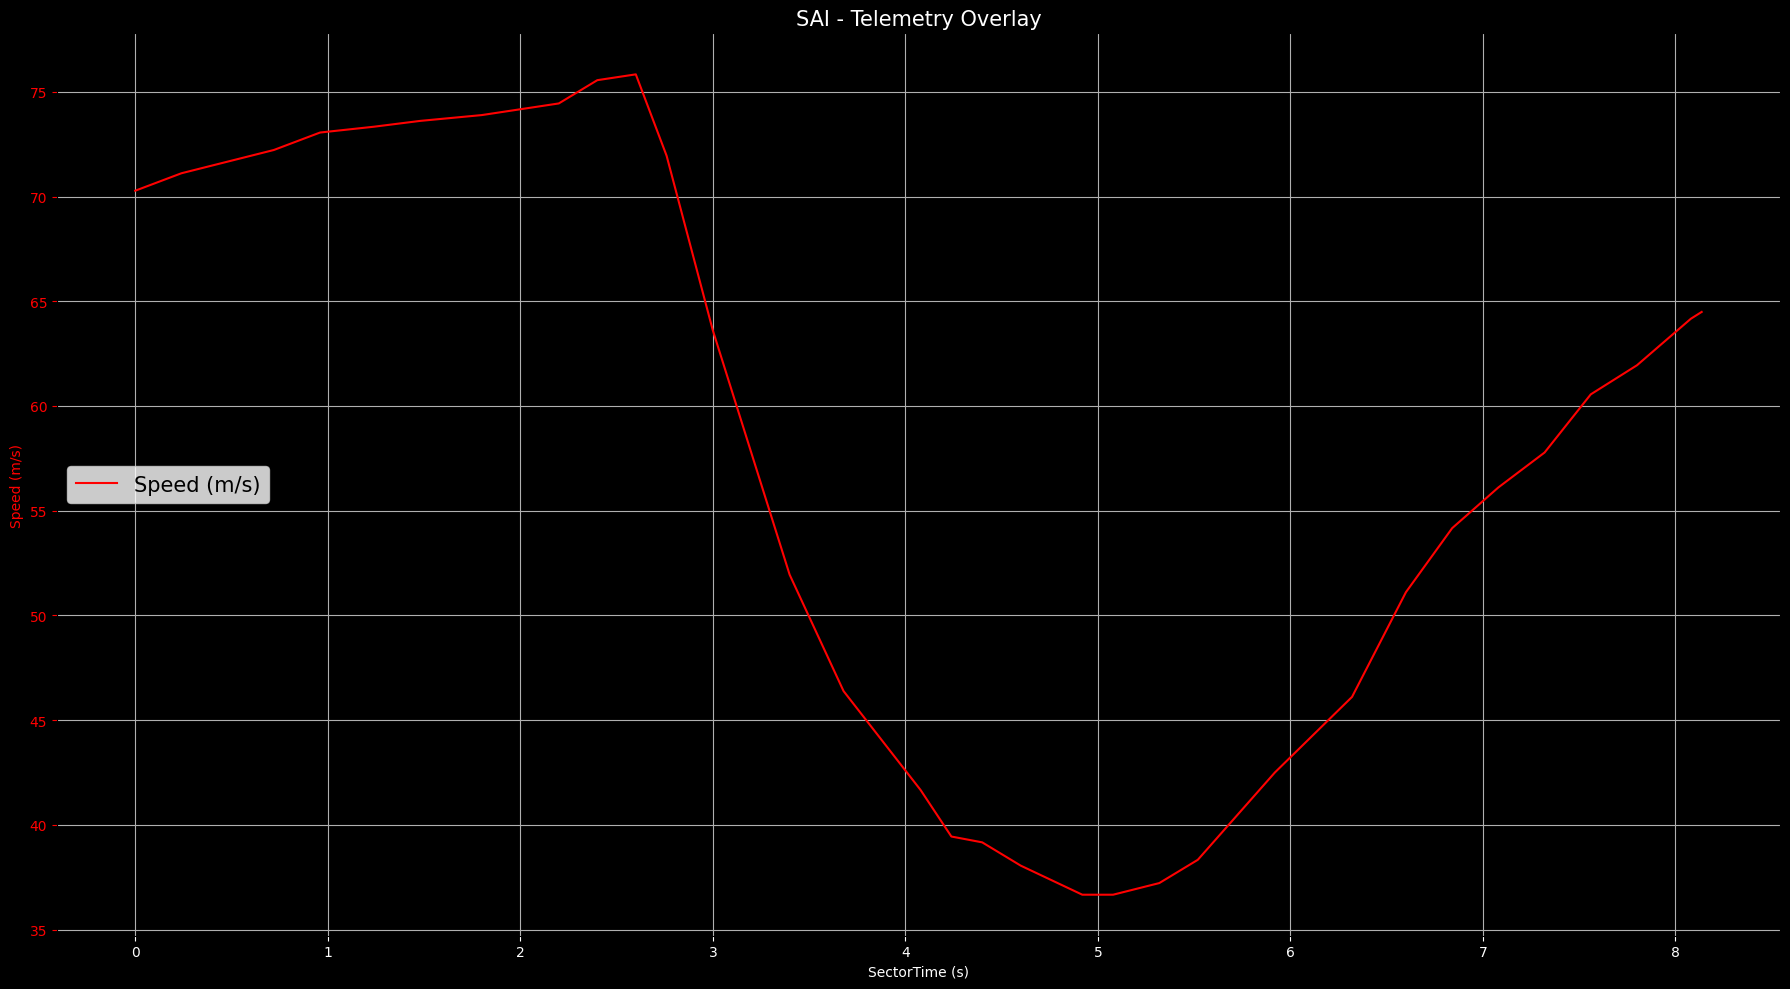

In [51]:
plots.plot_single_driver_telemetry(sainz_corner_telemetry, sainz, time_col='SectorTime (s)', telemetry_cols=[
    speed
])

Q2 data for Charles Leclerc, Ferrari

In [52]:
q1, q2, q3 = session.get_laps(leclerc).split_qualifying_sessions()
leclerc_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

leclerc_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=sector_1_start, end=sector_1_end)
leclerc_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_sector1_telemetry, leclerc)

leclerc_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=sector_1_end, end=sector_2_end)
leclerc_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_sector2_telemetry, leclerc)

leclerc_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(leclerc_q2_telemetry, start=sector_2_end, end=sector_3_end)
leclerc_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(leclerc_sector3_telemetry, leclerc)
leclerc_sector3_telemetry_features = feature_engineering.TelemetryFeatures(leclerc_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

leclerc_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(leclerc_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

leclerc_time_converted_telemetry = feature_engineering.TelemetryFeatures(leclerc_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (leclerc_time_converted_telemetry['BrakesApplied'] == 1) & (leclerc_time_converted_telemetry['BrakesApplied'].shift() == 0)
leclerc_initial_max_brake = leclerc_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()


Descriptive Statistics - Charles Leclerc - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [53]:
leclerc_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(leclerc_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
leclerc_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(leclerc, leclerc_turn_dfs, leclerc_initial_max_brake)

leclerc_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,LEC,16,63,2.599,5.979823,5,1,1


Visualizations - Charles Leclerc - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe.  
Limit the number of features to maintain clarity.

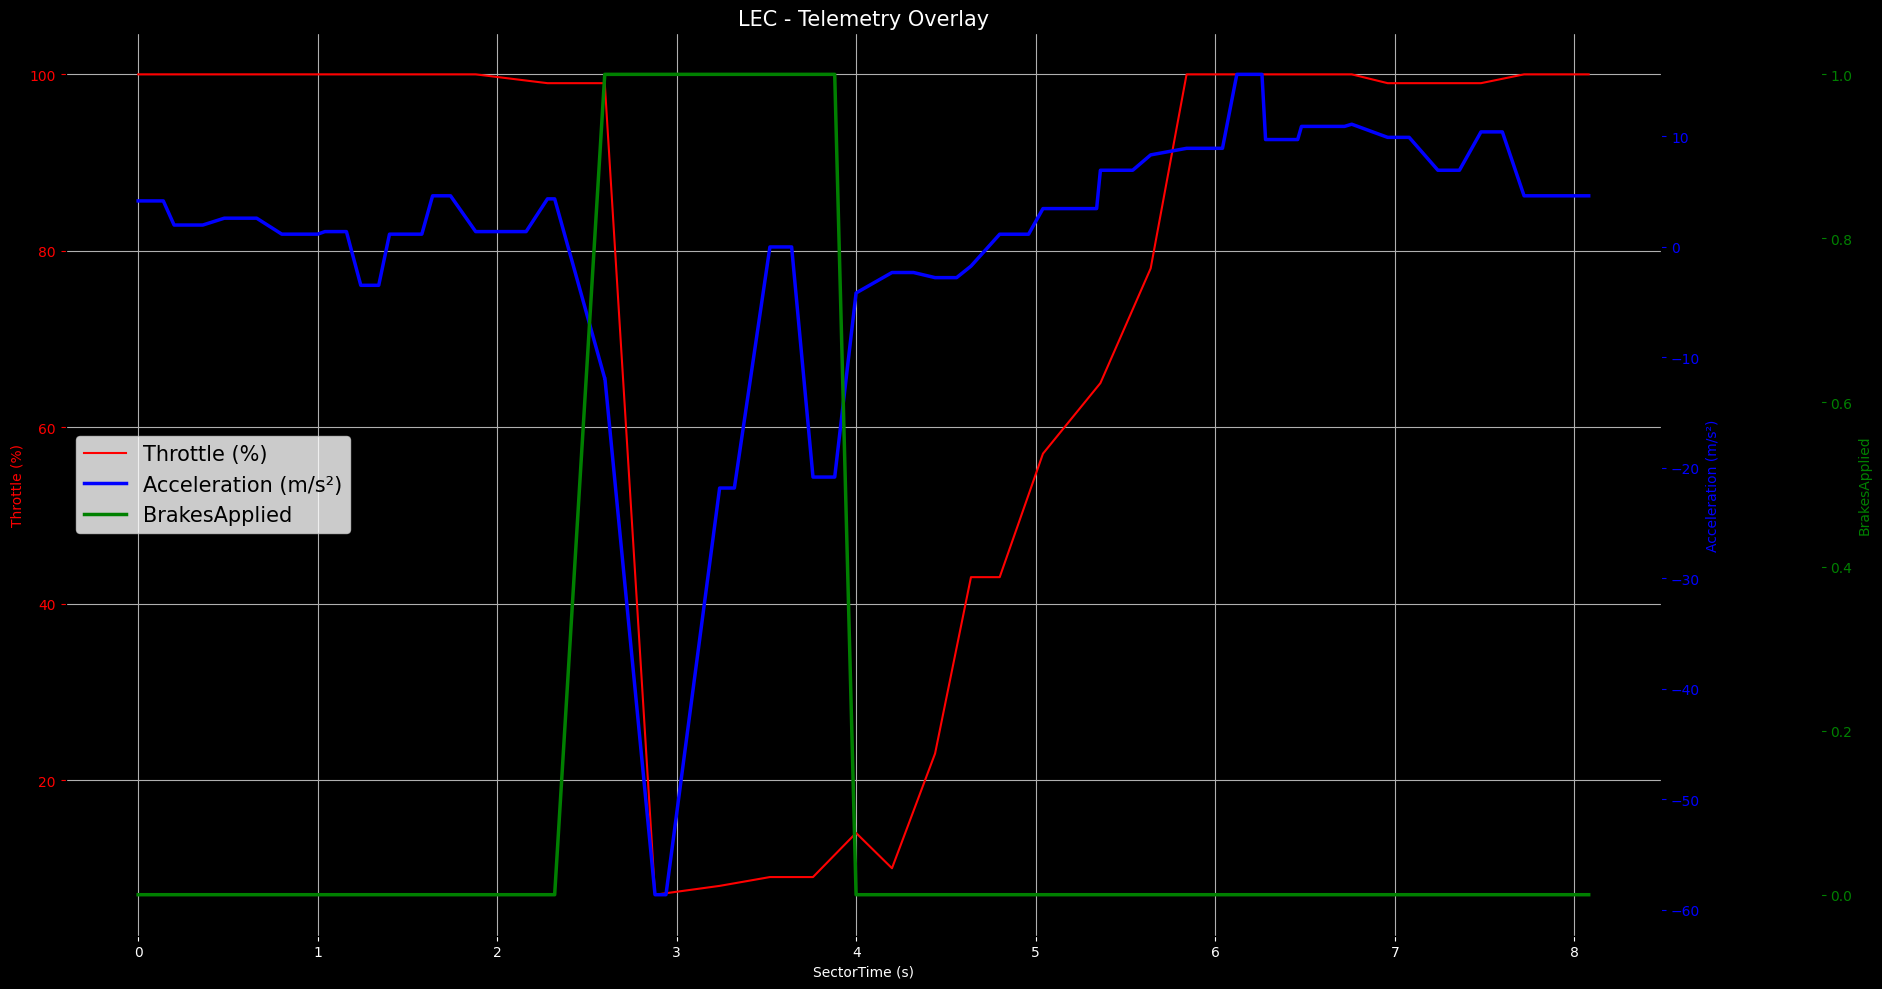

In [54]:
plots.plot_single_driver_telemetry(leclerc_corner_telemetry, leclerc, time_col='SectorTime (s)', telemetry_cols=[
    throttle, acceleration, brakes
])

Q3 data for Valtteri Bottas, Alfa Romeo

In [55]:
q1, q2, q3 = session.get_laps(bottas).split_qualifying_sessions()
bottas_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

bottas_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(bottas_q3_telemetry, start=sector_1_start, end=sector_1_end)
bottas_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(bottas_sector1_telemetry, bottas)

bottas_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(bottas_q3_telemetry, start=sector_1_end, end=sector_2_end)
bottas_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(bottas_sector2_telemetry, bottas)

bottas_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(bottas_q3_telemetry, start=sector_2_end, end=sector_3_end)
bottas_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(bottas_sector3_telemetry, bottas)
bottas_sector3_telemetry_features = feature_engineering.TelemetryFeatures(bottas_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

bottas_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(bottas_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

bottas_time_converted_telemetry = feature_engineering.TelemetryFeatures(bottas_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (bottas_time_converted_telemetry['BrakesApplied'] == 1) & (bottas_time_converted_telemetry['BrakesApplied'].shift() == 0)
bottas_initial_max_brake = bottas_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()


Descriptive Statistics - Valtteri Bottas - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [56]:
bottas_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(bottas_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
bottas_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(bottas, bottas_turn_dfs, bottas_initial_max_brake)

bottas_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,BOT,16,65,2.804,4.868446,4,2,1


Visualizations - Valtteri Bottas - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe.  
Limit the number of features to maintain clarity.

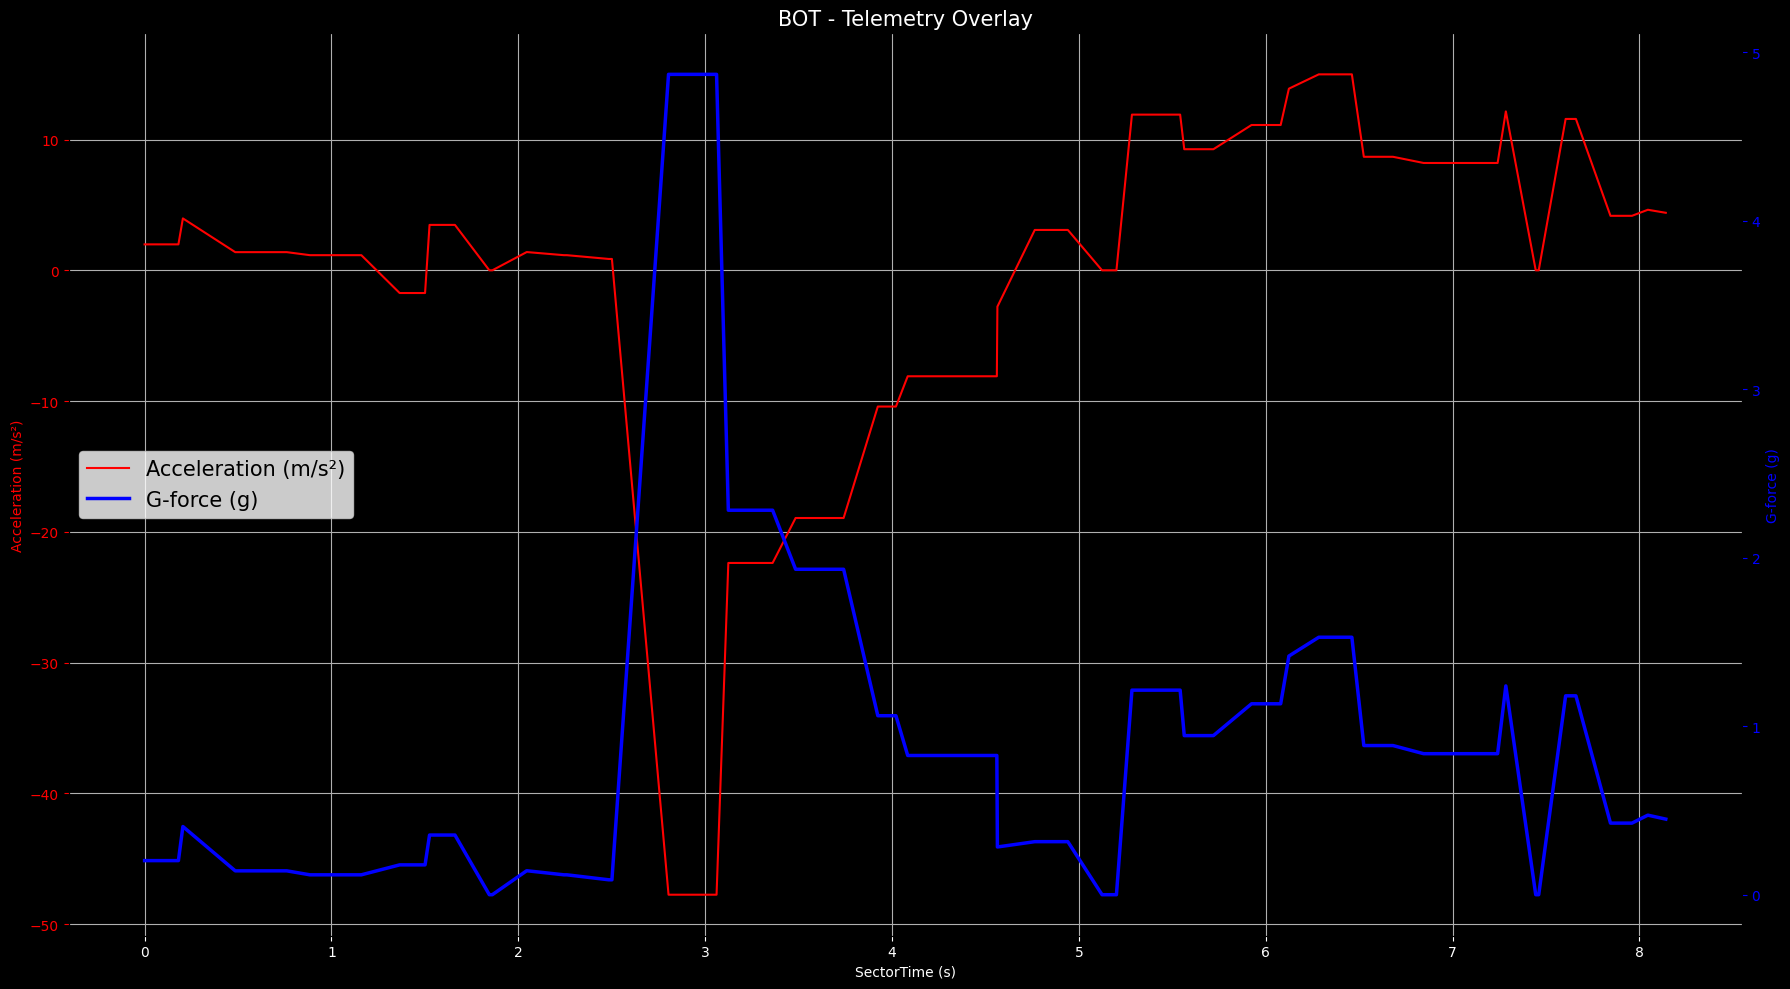

In [57]:
plots.plot_single_driver_telemetry(bottas_corner_telemetry, bottas, time_col='SectorTime (s)', telemetry_cols=[
    acceleration, g_force
])

Q3 data for Fernando Alonso, Aston Martin

In [58]:
q1, q2, q3 = session.get_laps(alonso).split_qualifying_sessions()
alonso_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

alonso_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=sector_1_start, end=sector_1_end)
alonso_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_sector1_telemetry, alonso)

alonso_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=sector_1_end, end=sector_2_end)
alonso_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_sector2_telemetry, alonso)

alonso_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(alonso_q3_telemetry, start=sector_2_end, end=sector_3_end)
alonso_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(alonso_sector3_telemetry, alonso)
alonso_sector3_telemetry_features = feature_engineering.TelemetryFeatures(alonso_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

alonso_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(alonso_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

alonso_time_converted_telemetry = feature_engineering.TelemetryFeatures(alonso_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (alonso_time_converted_telemetry['BrakesApplied'] == 1) & (alonso_time_converted_telemetry['BrakesApplied'].shift() == 0)
alonso_initial_max_brake = alonso_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()


Descriptive Statistics - Fernando Alonso - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [59]:
alonso_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(alonso_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
alonso_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(alonso, alonso_turn_dfs, alonso_initial_max_brake)

alonso_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,ALO,16,63,2.721,3.806235,6,3,1


Visualizations - Fernando Alonso - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe.  
Limit the number of features to maintain clarity.

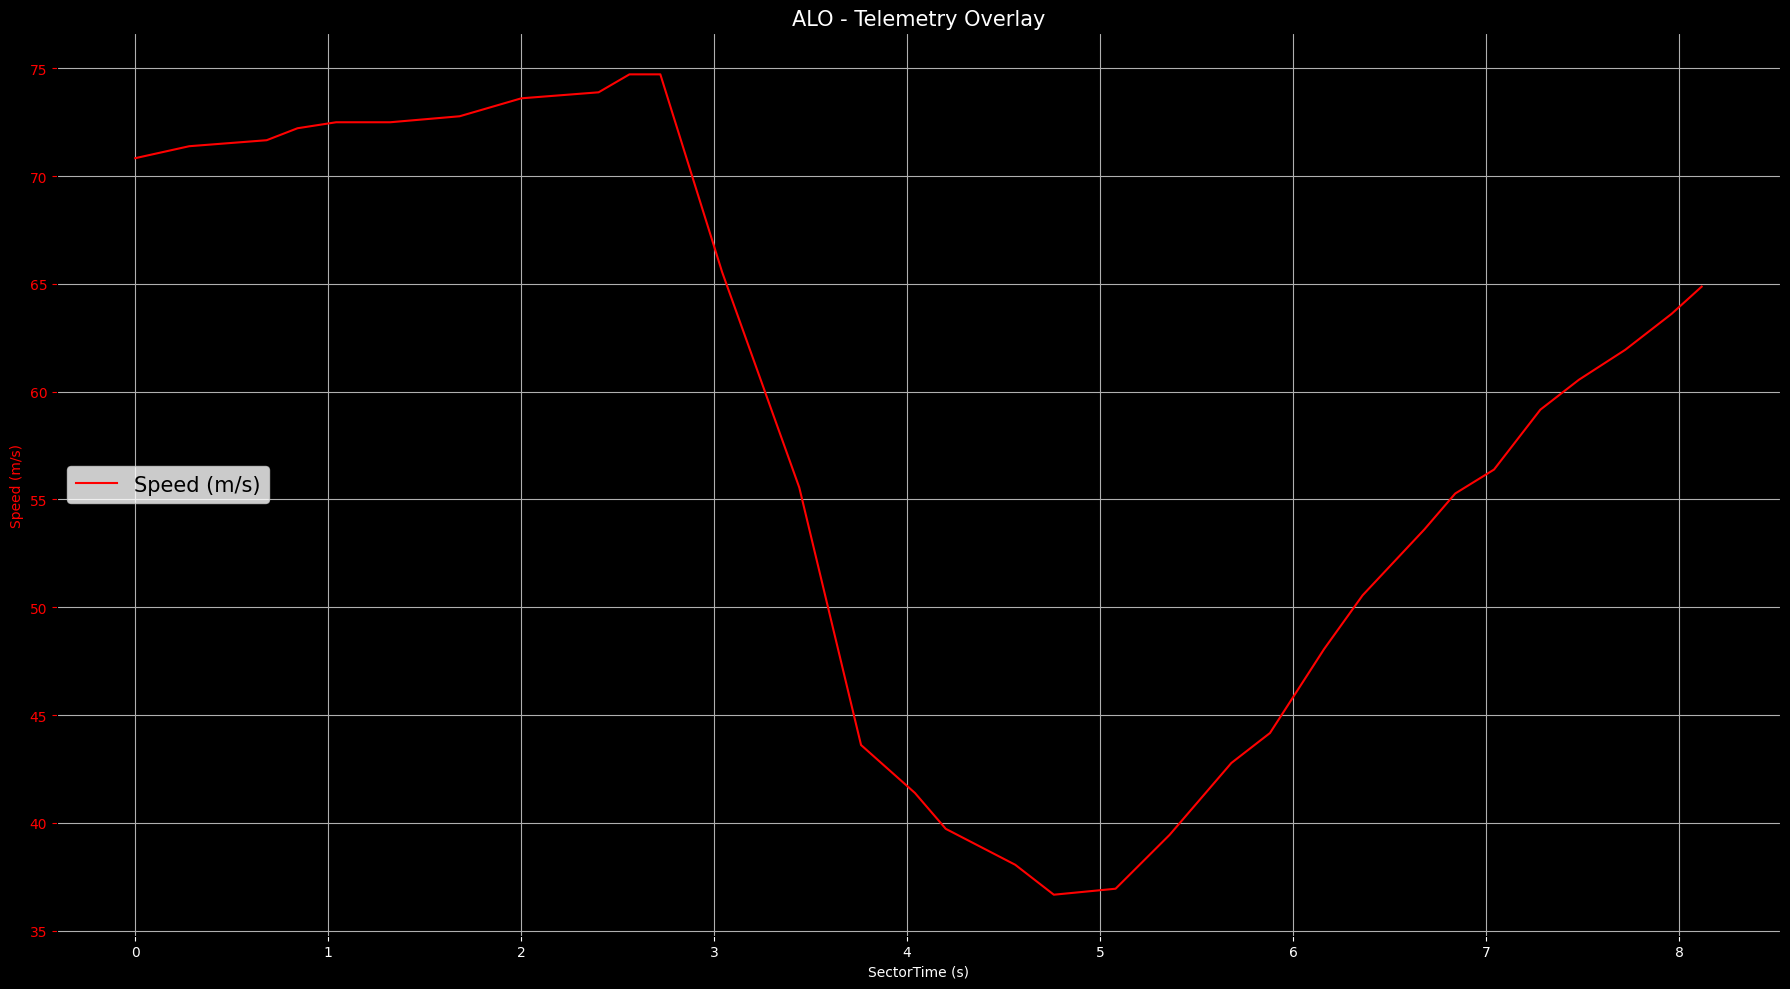

In [60]:
plots.plot_single_driver_telemetry(alonso_corner_telemetry, alonso, time_col='SectorTime (s)', telemetry_cols=[
    speed
])

Q2 data for Lance Stroll, Aston Martin

In [61]:
q1, q2, q3 = session.get_laps(stroll).split_qualifying_sessions()
stroll_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

stroll_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=sector_1_start, end=sector_1_end)
stroll_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_sector1_telemetry, stroll)

stroll_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=sector_1_end, end=sector_2_end)
stroll_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_sector2_telemetry, stroll)

stroll_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(stroll_q2_telemetry, start=sector_2_end, end=sector_3_end)
stroll_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(stroll_sector3_telemetry, stroll)
stroll_sector3_telemetry_features = feature_engineering.TelemetryFeatures(stroll_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

stroll_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(stroll_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

stroll_time_converted_telemetry = feature_engineering.TelemetryFeatures(stroll_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (stroll_time_converted_telemetry['BrakesApplied'] == 1) & (stroll_time_converted_telemetry['BrakesApplied'].shift() == 0)
stroll_initial_max_brake = stroll_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()


Descriptive Statistics - Lance Stroll - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [62]:
stroll_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(stroll_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
stroll_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(stroll, stroll_turn_dfs, stroll_initial_max_brake)
stroll_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,STR,16,61,2.8,5.355066,4,3,1


Visualizations - Lance Stroll - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe.  
Limit the number of features to maintain clarity.

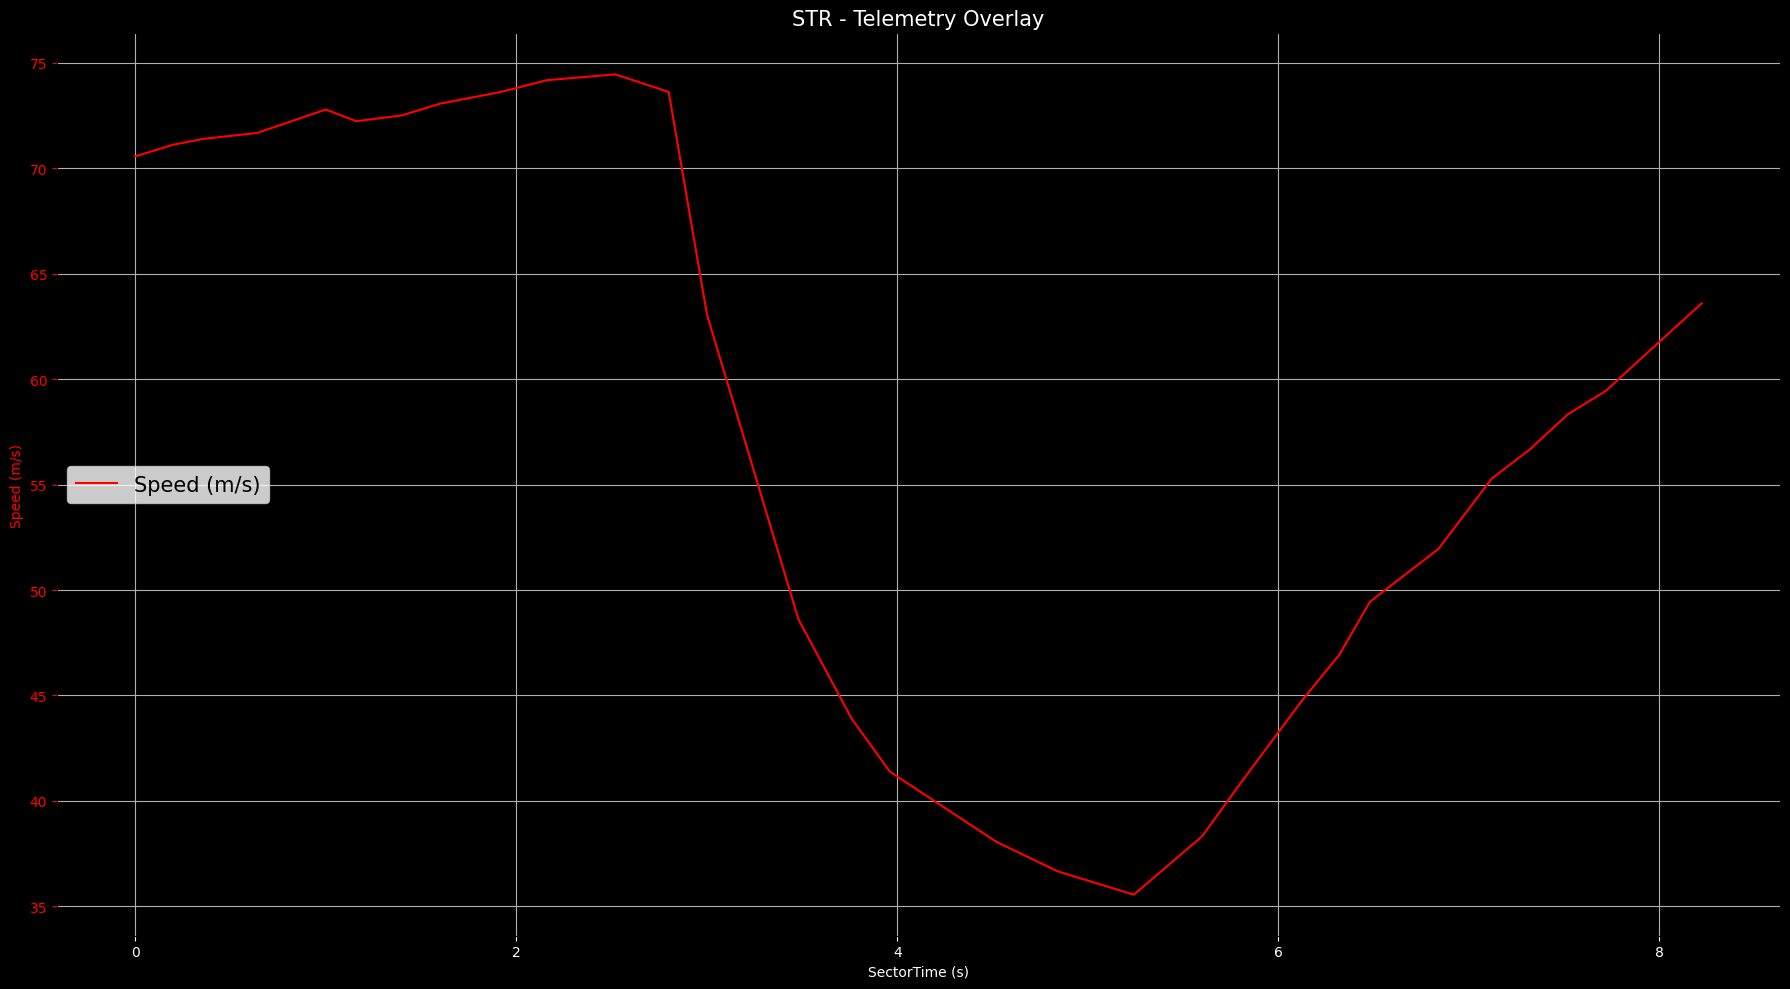

In [63]:
plots.plot_single_driver_telemetry(stroll_corner_telemetry, stroll, time_col='SectorTime (s)', telemetry_cols=[
    speed
])

Q3 data for Pierre Gasly, Alpine

In [64]:
q1, q2, q3 = session.get_laps(gasly).split_qualifying_sessions()
gasly_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

gasly_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=sector_1_start, end=sector_1_end)
gasly_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_sector1_telemetry, gasly)

gasly_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=sector_1_end, end=sector_2_end)
gasly_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_sector2_telemetry, gasly)

gasly_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(gasly_q3_telemetry, start=sector_2_end, end=sector_3_end)
gasly_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(gasly_sector3_telemetry, gasly)
gasly_sector3_telemetry_features = feature_engineering.TelemetryFeatures(gasly_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

gasly_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(gasly_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

gasly_time_converted_telemetry = feature_engineering.TelemetryFeatures(gasly_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (gasly_time_converted_telemetry['BrakesApplied'] == 1) & (gasly_time_converted_telemetry['BrakesApplied'].shift() == 0)
gasly_initial_max_brake = gasly_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()


Descriptive Statistics - Pierre Gasly - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [65]:
gasly_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(gasly_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
gasly_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(gasly, gasly_turn_dfs, gasly_initial_max_brake)

gasly_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,GAS,16,66,3.043,4.956962,5,2,1


Visualizations - Pierre Gasly - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe.  
Limit the number of features to maintain clarity.

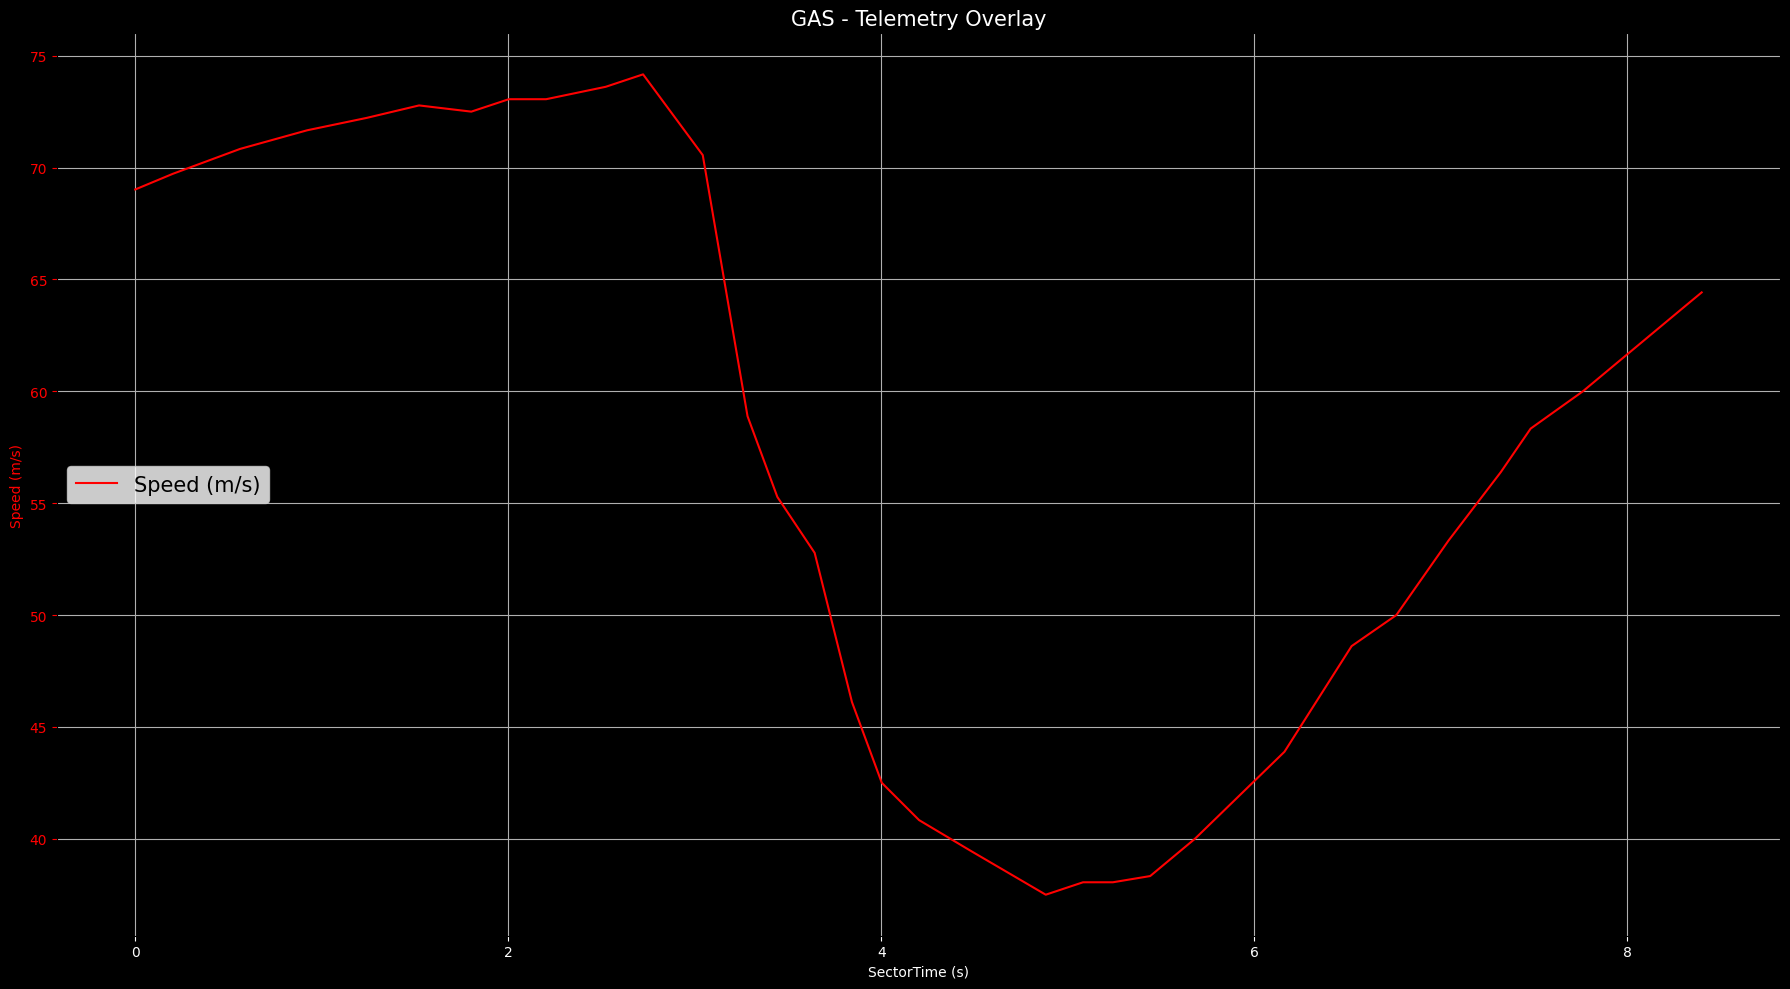

In [66]:
plots.plot_single_driver_telemetry(gasly_corner_telemetry, gasly, time_col='SectorTime (s)', telemetry_cols=[
    speed
])

Q3 data for Nico Hulkenberg, Haas

In [67]:
q1, q2, q3 = session.get_laps(hulkenberg).split_qualifying_sessions()
hulkenberg_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

hulkenberg_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=sector_1_start, end=sector_1_end)
hulkenberg_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_sector1_telemetry, hulkenberg)

hulkenberg_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=sector_1_end, end=sector_2_end)
hulkenberg_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_sector2_telemetry, hulkenberg)

hulkenberg_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(hulkenberg_q3_telemetry, start=sector_2_end, end=sector_3_end)
hulkenberg_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(hulkenberg_sector3_telemetry, hulkenberg)
hulkenberg_sector3_telemetry_features = feature_engineering.TelemetryFeatures(hulkenberg_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

hulkenberg_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(hulkenberg_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

hulkenberg_time_converted_telemetry = feature_engineering.TelemetryFeatures(hulkenberg_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (hulkenberg_time_converted_telemetry['BrakesApplied'] == 1) & (hulkenberg_time_converted_telemetry['BrakesApplied'].shift() == 0)
hulkenberg_initial_max_brake = hulkenberg_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()


Descriptive Statistics - Nico Hulkenberg - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [68]:
hulkenberg_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(hulkenberg_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
hulkenberg_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(hulkenberg, hulkenberg_turn_dfs, hulkenberg_initial_max_brake)

hulkenberg_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,HUL,16,67,2.88,6.7273,4,2,1


Visualizations - Nico Hulkenberg - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe.  
Limit the number of features to maintain clarity.

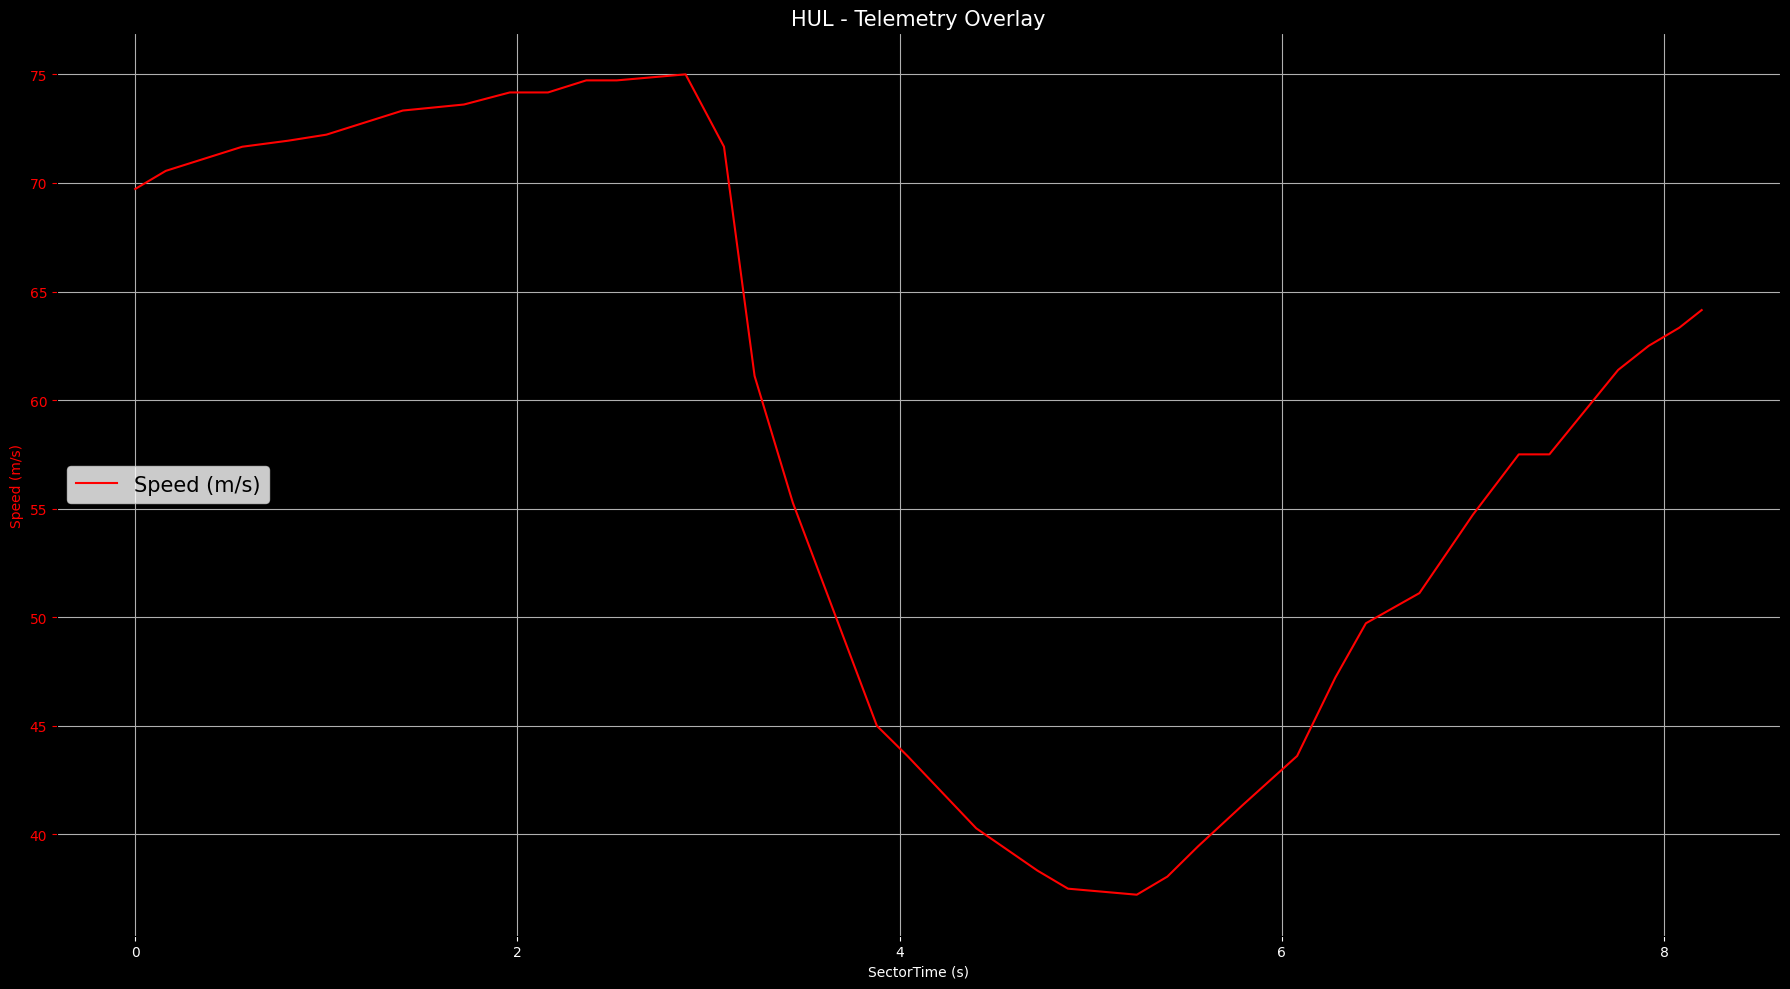

In [69]:
plots.plot_single_driver_telemetry(hulkenberg_corner_telemetry, hulkenberg, time_col='SectorTime (s)', telemetry_cols=[
    speed
])

Q2 data for Kevin Magnussen, Haas

In [70]:
q1, q2, q3 = session.get_laps(magnussen).split_qualifying_sessions()
magnussen_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

magnussen_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=sector_1_start, end=sector_1_end)
magnussen_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_sector1_telemetry, magnussen)

magnussen_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=sector_1_end, end=sector_2_end)
magnussen_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_sector2_telemetry, magnussen)

magnussen_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(magnussen_q2_telemetry, start=sector_2_end, end=sector_3_end)
magnussen_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(magnussen_sector3_telemetry, magnussen)
magnussen_sector3_telemetry_features = feature_engineering.TelemetryFeatures(magnussen_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

magnussen_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(magnussen_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

magnussen_time_converted_telemetry = feature_engineering.TelemetryFeatures(magnussen_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (magnussen_time_converted_telemetry['BrakesApplied'] == 1) & (magnussen_time_converted_telemetry['BrakesApplied'].shift() == 0)
magnussen_initial_max_brake = magnussen_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()


Descriptive Statistics - Kevin Magnussen - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [71]:
magnussen_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(magnussen_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
magnussen_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(magnussen, magnussen_turn_dfs, magnussen_initial_max_brake)

magnussen_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,MAG,16,62,3.041,4.956958,4,2,1


Visualizations - Kevin Magnussen - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe.  
Limit the number of features to maintain clarity.

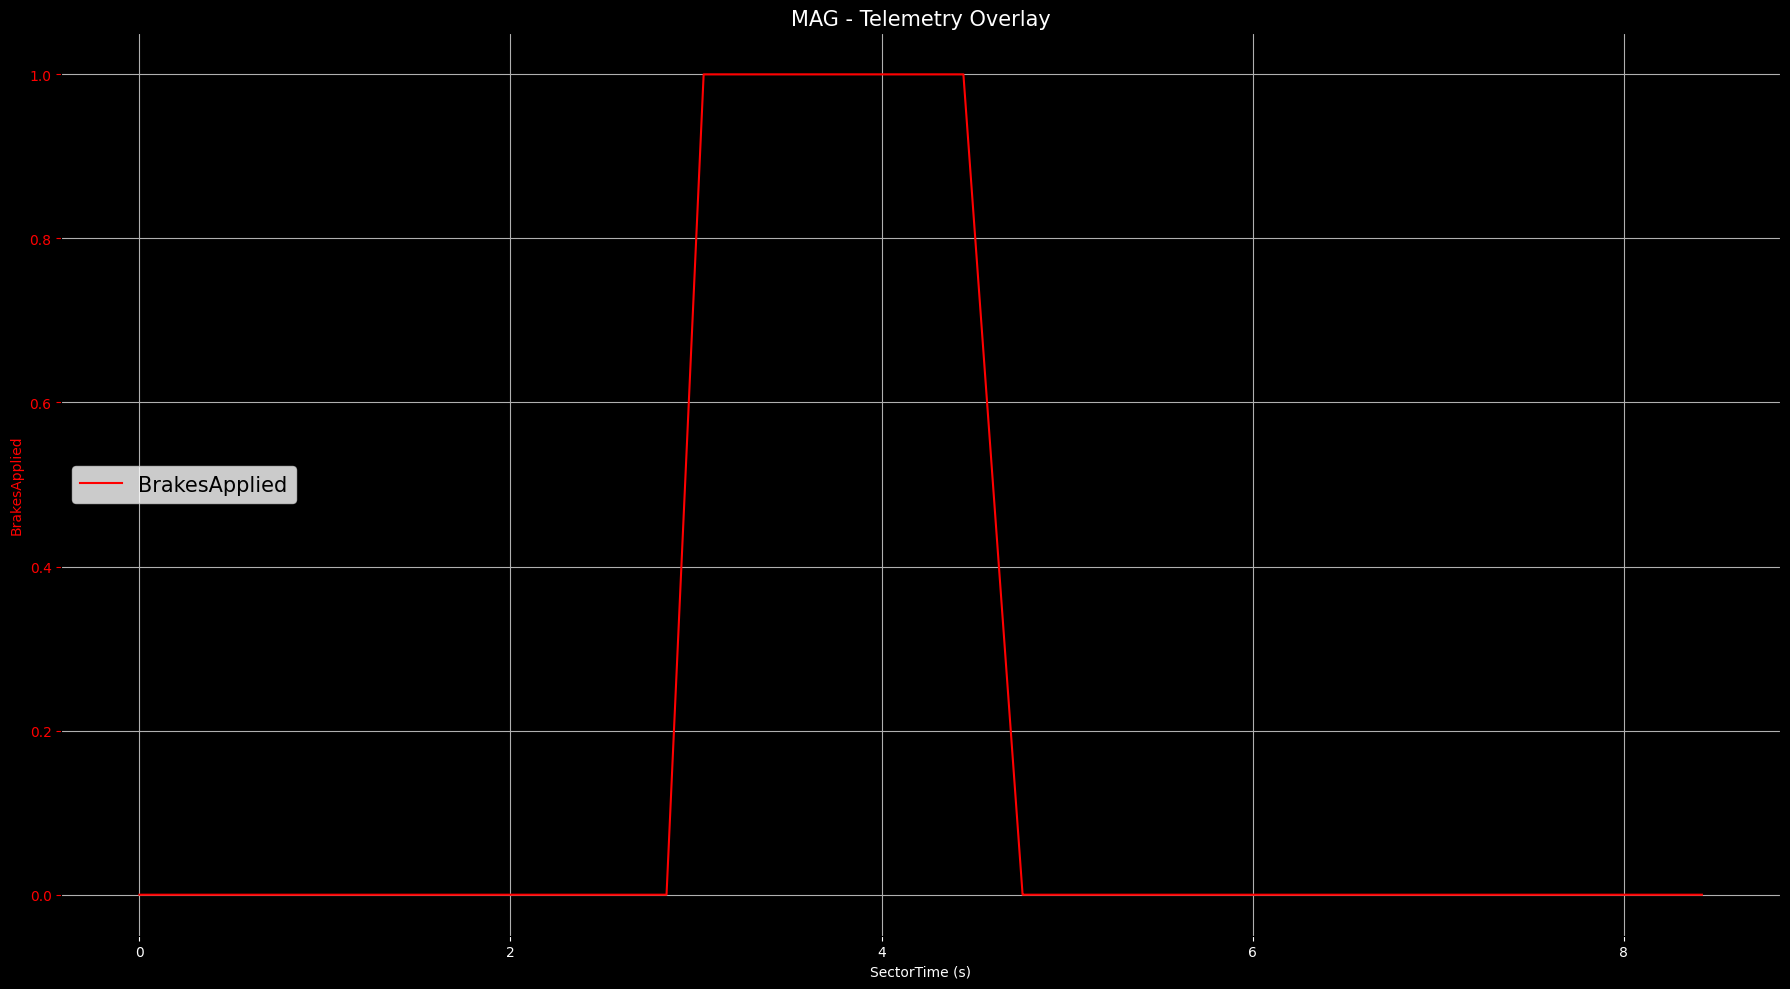

In [72]:
plots.plot_single_driver_telemetry(magnussen_corner_telemetry, magnussen, time_col='SectorTime (s)', telemetry_cols=[
    brakes
])

Q2 data for Liam Lawson, Visa CashApp

In [73]:
q1, q2, q3 = session.get_laps(lawson).split_qualifying_sessions()
lawson_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

lawson_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=sector_1_start, end=sector_1_end)
lawson_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_sector1_telemetry, lawson)

lawson_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=sector_1_end, end=sector_2_end)
lawson_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_sector2_telemetry, lawson)

lawson_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(lawson_q2_telemetry, start=sector_2_end, end=sector_3_end)
lawson_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(lawson_sector3_telemetry, lawson)
lawson_sector3_telemetry_features = feature_engineering.TelemetryFeatures(lawson_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

lawson_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(lawson_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

lawson_time_converted_telemetry = feature_engineering.TelemetryFeatures(lawson_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (lawson_time_converted_telemetry['BrakesApplied'] == 1) & (lawson_time_converted_telemetry['BrakesApplied'].shift() == 0)
lawson_initial_max_brake = lawson_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()


Descriptive Statistics - Liam Lawson - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [74]:
lawson_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(lawson_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
lawson_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(lawson, lawson_turn_dfs, lawson_initial_max_brake)

lawson_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,LAW,16,59,2.8,7.169885,4,2,1


Visualizations - Liam Lawson - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe.  
Limit the number of features to maintain clarity.

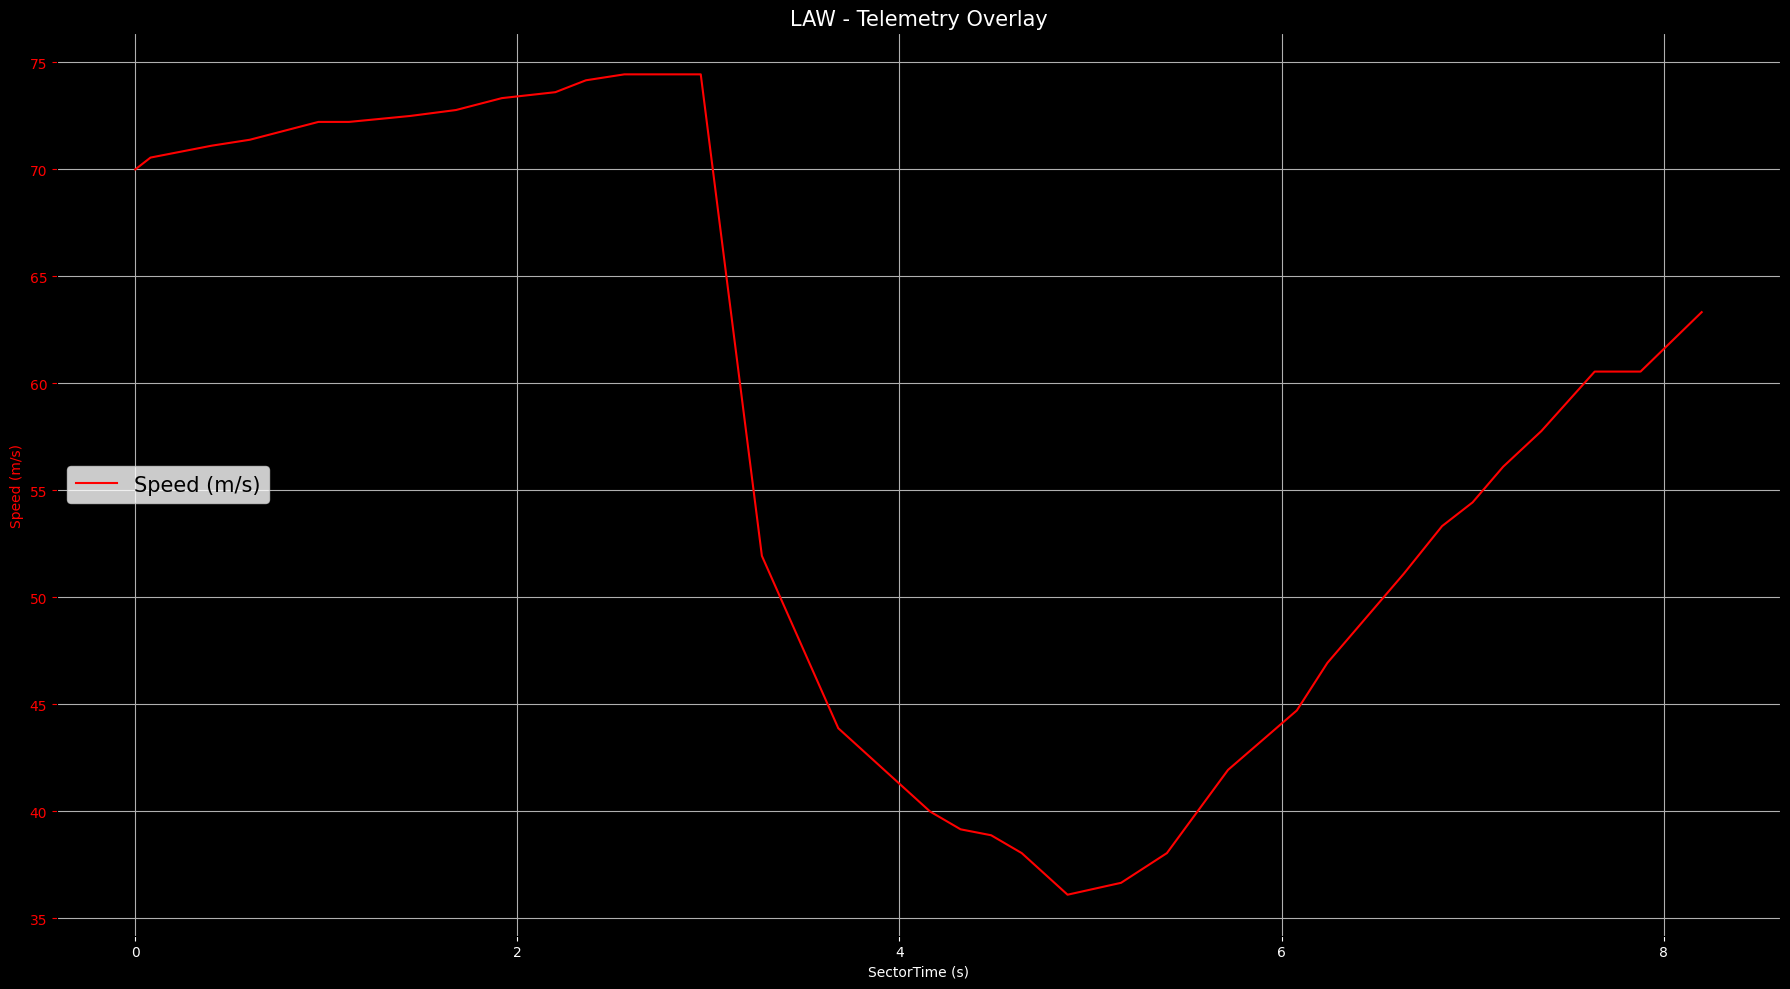

In [75]:
plots.plot_single_driver_telemetry(lawson_corner_telemetry, lawson, time_col='SectorTime (s)', telemetry_cols=[
    speed
])

Q2 data for Yuki Tsunoda, Visa CashApp

In [76]:
q1, q2, q3 = session.get_laps(tsunoda).split_qualifying_sessions()
tsunoda_q2_telemetry = session.get_telemetry(q2)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q2)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q2)[3])

tsunoda_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=sector_1_start, end=sector_1_end)
tsunoda_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_sector1_telemetry, tsunoda)

tsunoda_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=sector_1_end, end=sector_2_end)
tsunoda_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_sector2_telemetry, tsunoda)

tsunoda_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(tsunoda_q2_telemetry, start=sector_2_end, end=sector_3_end)
tsunoda_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(tsunoda_sector3_telemetry, tsunoda)
tsunoda_sector3_telemetry_features = feature_engineering.TelemetryFeatures(tsunoda_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

tsunoda_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(tsunoda_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

tsunoda_time_converted_telemetry = feature_engineering.TelemetryFeatures(tsunoda_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (tsunoda_time_converted_telemetry['BrakesApplied'] == 1) & (tsunoda_time_converted_telemetry['BrakesApplied'].shift() == 0)
tsunoda_initial_max_brake = tsunoda_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()


Descriptive Statistics - Yuki Tsunoda - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [77]:
tsunoda_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(tsunoda_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
tsunoda_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(tsunoda, tsunoda_turn_dfs, tsunoda_initial_max_brake)

tsunoda_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,TSU,16,61,2.681,4.184445,5,2,1


Visualizations - Yuki Tsunoda - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe.  
Limit the number of features to maintain clarity.

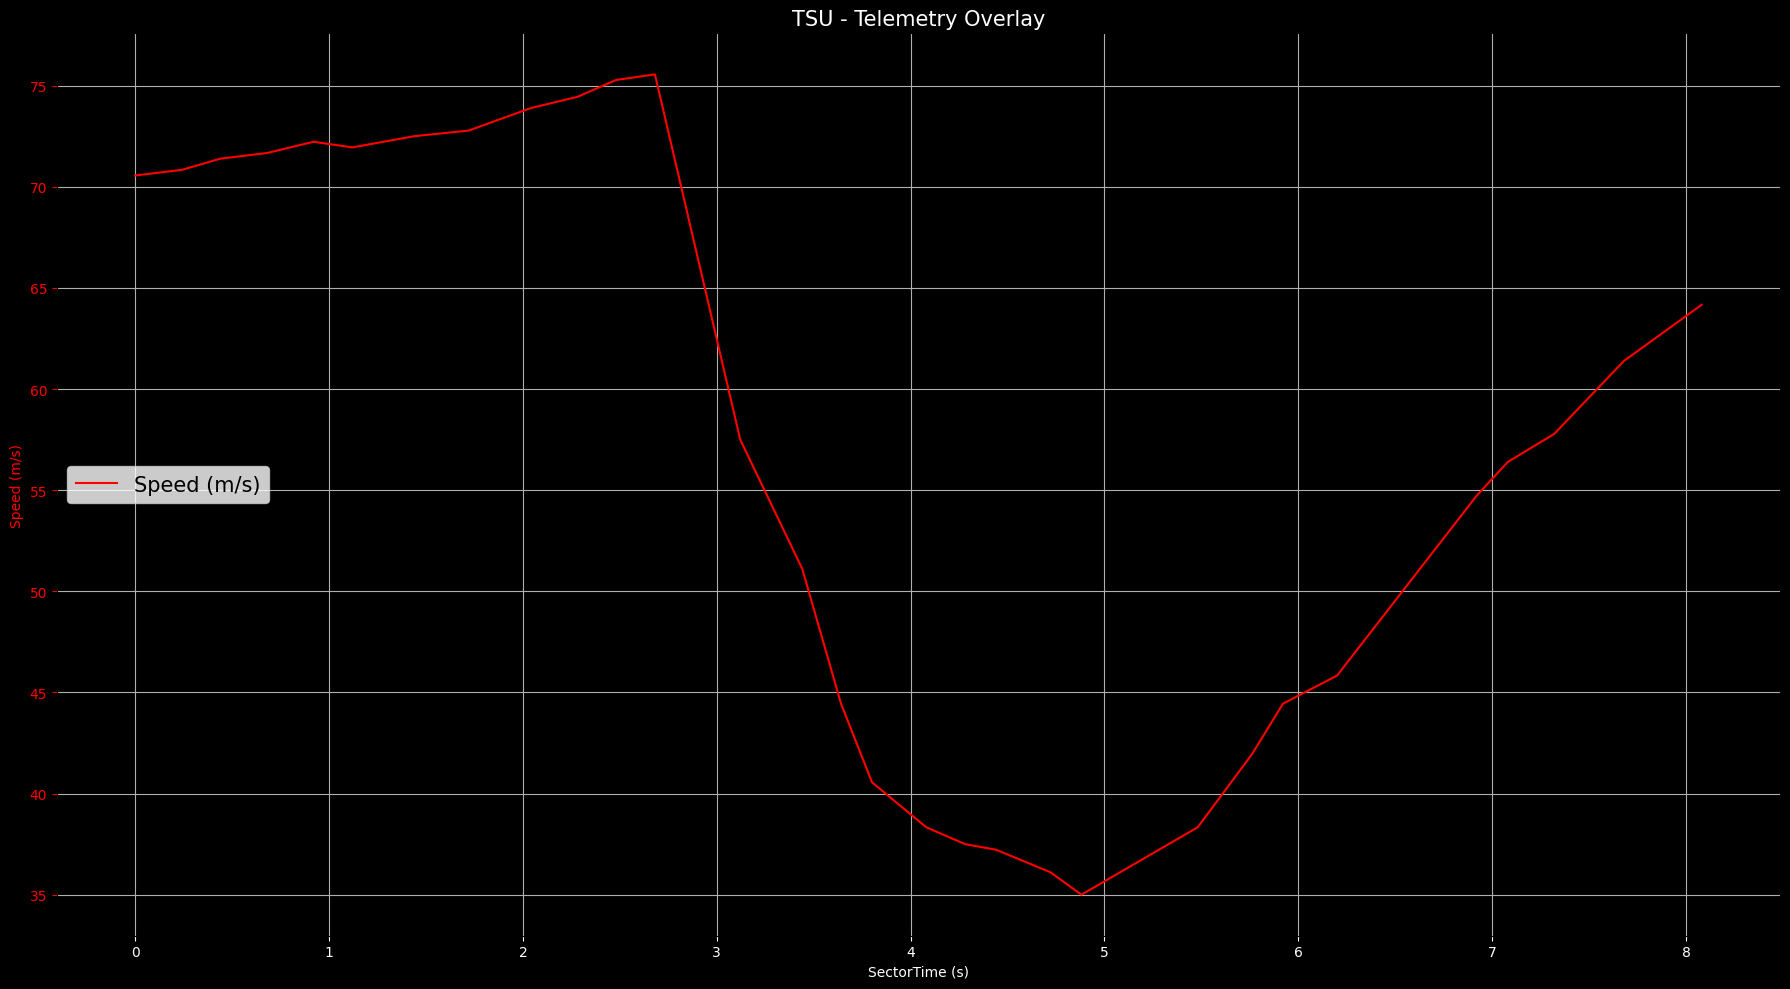

In [78]:
plots.plot_single_driver_telemetry(tsunoda_corner_telemetry, tsunoda, time_col='SectorTime (s)', telemetry_cols=[
    speed
])

Q3 data for George Russell, Mercedes

In [79]:
q1, q2, q3 = session.get_laps(russell).split_qualifying_sessions()
russell_q3_telemetry = session.get_telemetry(q3)

sector_1_start = str(f1_pandas_helpers.get_fastest_lap_details(q3)[0])
sector_1_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[1])
sector_2_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[2])
sector_3_end = str(f1_pandas_helpers.get_fastest_lap_details(q3)[3])

russell_sector1_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=sector_1_start, end=sector_1_end)
russell_sector1_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_sector1_telemetry, russell)

russell_sector2_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=sector_1_end, end=sector_2_end)
russell_sector2_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_sector2_telemetry, russell)

russell_sector3_telemetry = f1_pandas_helpers.filter_timestamp_range(russell_q3_telemetry, start=sector_2_end, end=sector_3_end)
russell_sector3_telemetry_cleaned = telemetry_cleaning.clean_driver_sector_telemetry(russell_sector3_telemetry, russell)
russell_sector3_telemetry_features = feature_engineering.TelemetryFeatures(russell_sector3_telemetry_cleaned).acceleration().jerk().g_force().get_features_df()

russell_corner_telemetry = telemetry_cleaning.filter_corner_telemetry(russell_sector3_telemetry_features, corner_position_cleaned, critical_turn[0], radius)

russell_time_converted_telemetry = feature_engineering.TelemetryFeatures(russell_corner_telemetry).convert_sector_time_to_seconds().get_features_df()
mask = (russell_time_converted_telemetry['BrakesApplied'] == 1) & (russell_time_converted_telemetry['BrakesApplied'].shift() == 0)
russell_initial_max_brake = russell_time_converted_telemetry.loc[mask, 'SectorTime (s)'].min()


Descriptive Statistics - George Russell - The code below concatenates descriptive statistics for the driver at each turn in the critical_turn list into a single DataFrame.

In [80]:
russell_turn_dfs = [(turn, telemetry_cleaning.filter_corner_telemetry(russell_sector3_telemetry_features, corner_position_cleaned, turn, radius)) for turn in critical_turn]
russell_eda_summary = f1_pandas_helpers.get_driver_eda_multiple_turns(russell, russell_turn_dfs, russell_initial_max_brake)

russell_eda_summary

,Driver,Turn,Row Count,Initial Brake,Max Gs,Gear Shifts,Throttle Events,Brake Events
0,RUS,16,54,3.003,4.248822,5,2,1


Visualizations - George Russell - This multi-axis plot can dynamically display telemetry data to reveal correlations and driver behaviors for a given driver dataframe.  
Limit the number of features to maintain clarity.

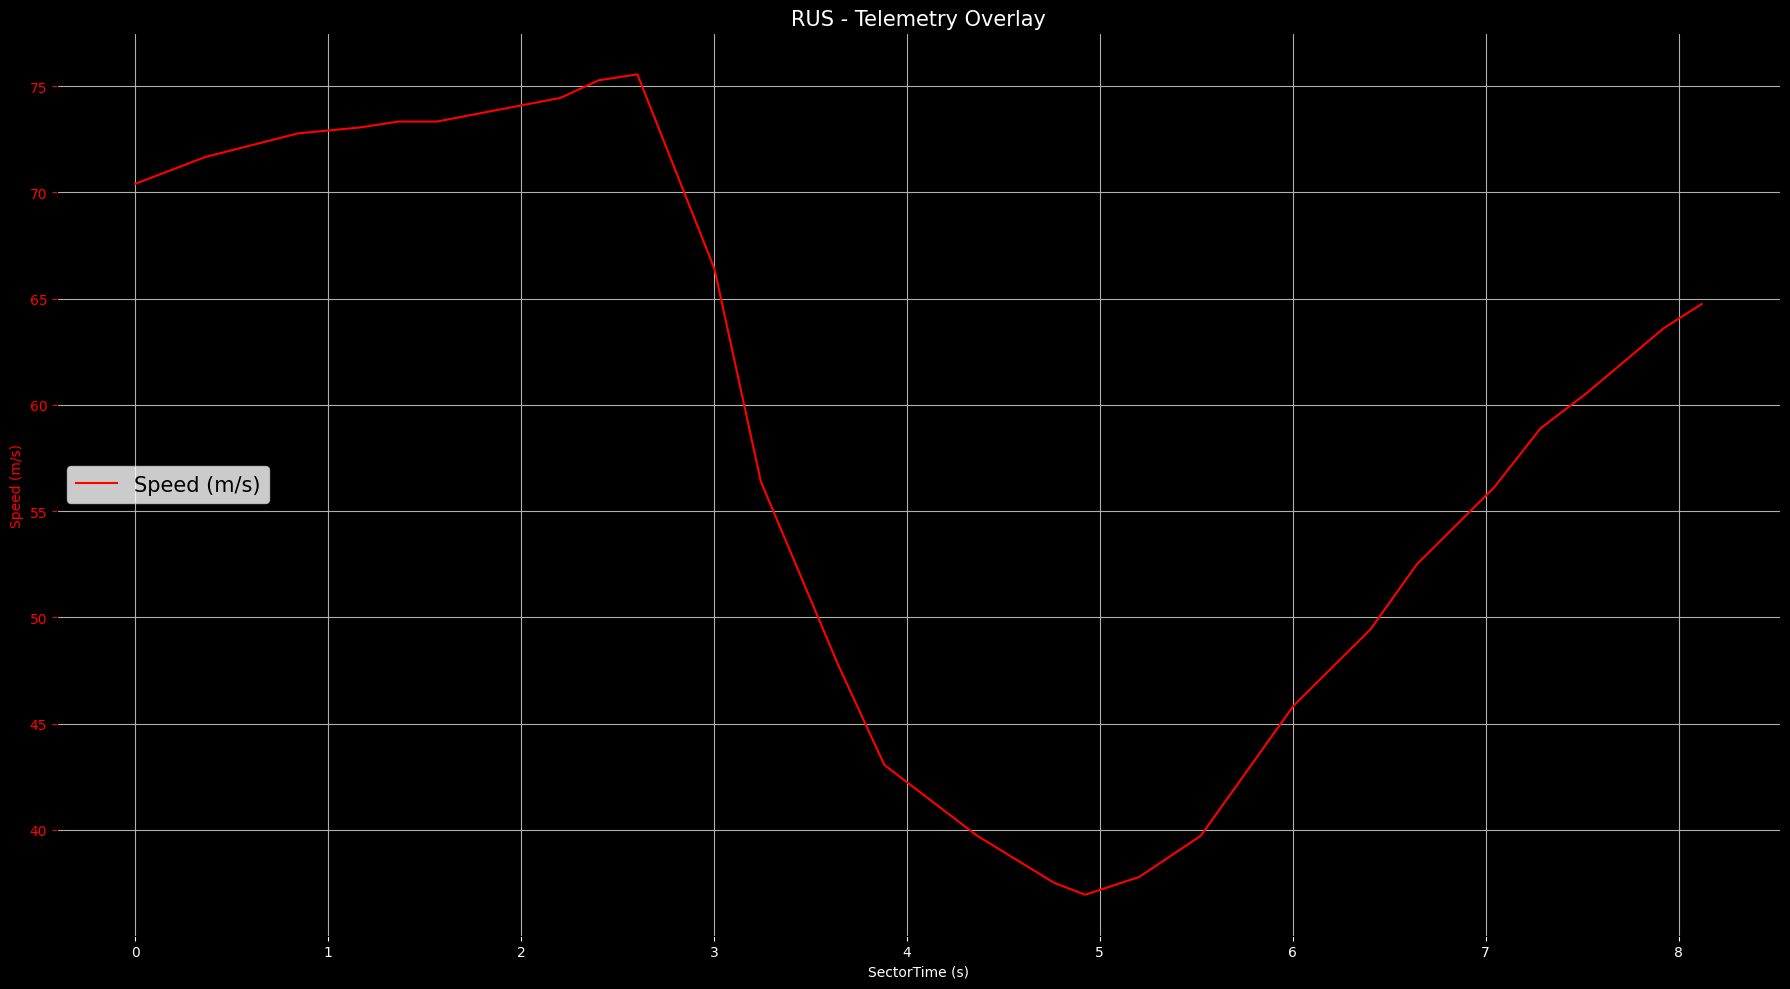

In [81]:
plots.plot_single_driver_telemetry(russell_corner_telemetry, russell, time_col='SectorTime (s)', telemetry_cols=[
    speed
])